# Equity Hedgeing

Welcome to this project on equity heding. In this project, I design and implemented an algorithm to hedge a target security (ie. stock) over a certain period of time. The goal of the algorithm is to find out a basket of securities, from a universe of secutiries, to hedge a set of target securities. Specifically, I will perform the following steps:

**1. Data exploration**
- Visualize the existing trends in the universe of securities as well as the four target securities
- Cleaning the data
- Split the data into training and validation sets

**2. Model development**
- Use the training set to develop a machine learning model that predicts the performances of securities over time 
- Use the validation set for hyperparameter tuning

**3. Hedging basket proposal**
- Find a set of securities (<5 securities) to hedge the target security with

Lets imports all the packages we need in the project.

In [138]:
import numpy as np
import pandas as pd
import missingno as msno
import sys
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
from keras.losses import logcosh, mean_absolute_percentage_error
%matplotlib inline

## 1- Data Exploration

In this section, we are interested in answering the following questions:

1. Is there missing data in the dataset?
    - If yes, devise a plan to for data imputation
2. Combine the datasets (security prices + categorical variables) into a single set
3. What is the distribution of the data?
    - We may need to scale the data for faster convergence of the learning algorithm
4. Split the data into training and validation sets

### 1.1- Missing data imputation

Lets explore the data to see if there are any pieces of expected data missing. The `missingno` library helps us visualize that.

In [2]:
filename = 'data/X.csv'
df = pd.read_csv(filename)
print('shape of data:', df.shape)
df.head()

shape of data: (262, 445)


,Date,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,...,x_434,x_435,x_436,x_437,x_438,x_439,x_440,x_441,x_442,x_443
0,11/11/2014,12.130498,12.119809,12.154613,12.058736,12.185463,12.228182,12.099484,12.113096,12.083516,...,12.085897,12.175002,12.111746,12.119638,12.072874,12.106779,12.168357,12.340382,12.448269,12.111459
1,12/11/2014,12.173541,11.662179,11.493724,11.740062,12.263239,12.714563,13.566741,12.234096,12.275163,...,11.916660,12.260203,12.260436,12.451905,12.119624,12.063758,12.206699,11.977715,12.270892,12.205741
2,13/11/2014,12.399584,12.044216,11.386044,11.717131,12.330932,12.053121,12.187032,12.405628,12.371092,...,11.988281,12.230816,12.179296,12.304142,12.191510,12.313920,12.149826,12.073795,12.215148,12.128199
3,14/11/2014,12.368701,11.987042,11.315223,11.636306,12.371742,12.392981,12.567660,12.372280,12.509437,...,11.863985,12.285775,12.134053,12.217076,12.071716,12.207487,12.077161,12.080112,12.284192,12.267953
4,15/11/2014,12.485055,11.836163,11.582712,11.809421,12.363644,12.388525,12.799575,12.633196,12.525672,...,11.874021,12.270080,12.200462,12.308393,12.029526,12.347625,12.096129,12.186137,12.265990,12.073159


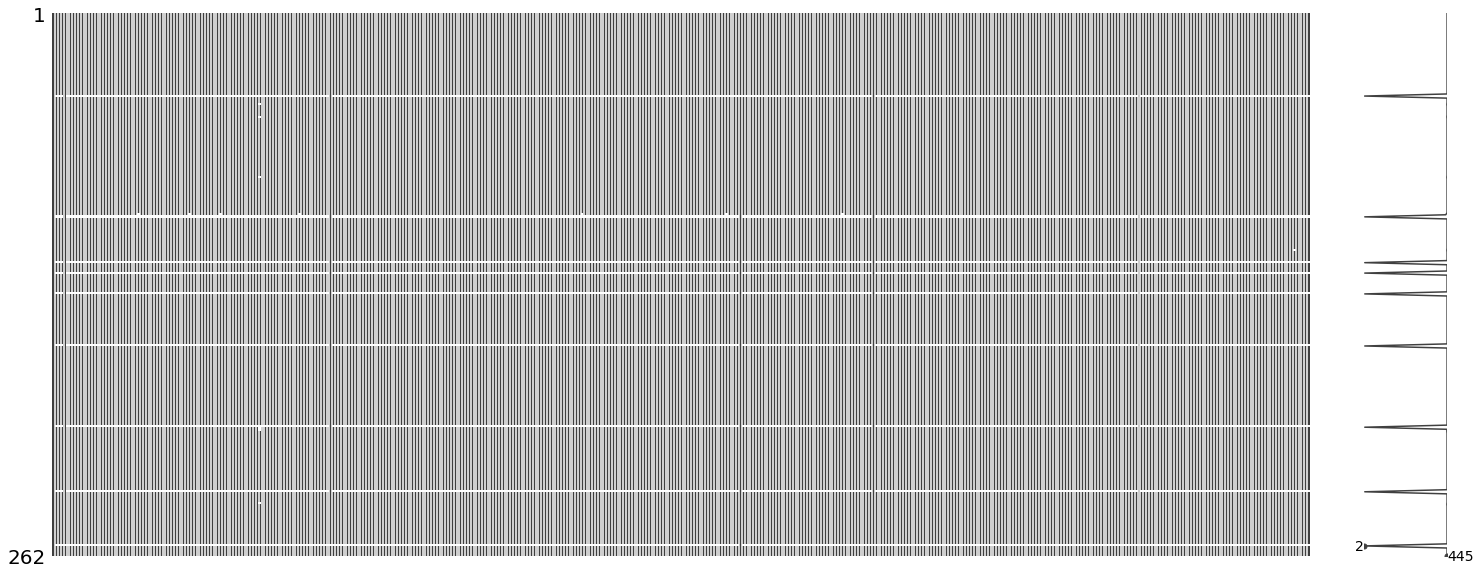

In [3]:
# lets see which rows contain missing data
msno.matrix(df)

Notice that the value of many securities are not recorded on certain dates. To impute the missing data, we could delete the rows with missing values (9 rows out of 262 rows, accounting for ~3.5% of the data). While this seems easy and plausible, I suggest imputing the data by interpolating each missing value as the arithmetic mean of the preceeding and following values. The cell below uses pandas's utility function to linearly interpolate the missing values as just described.

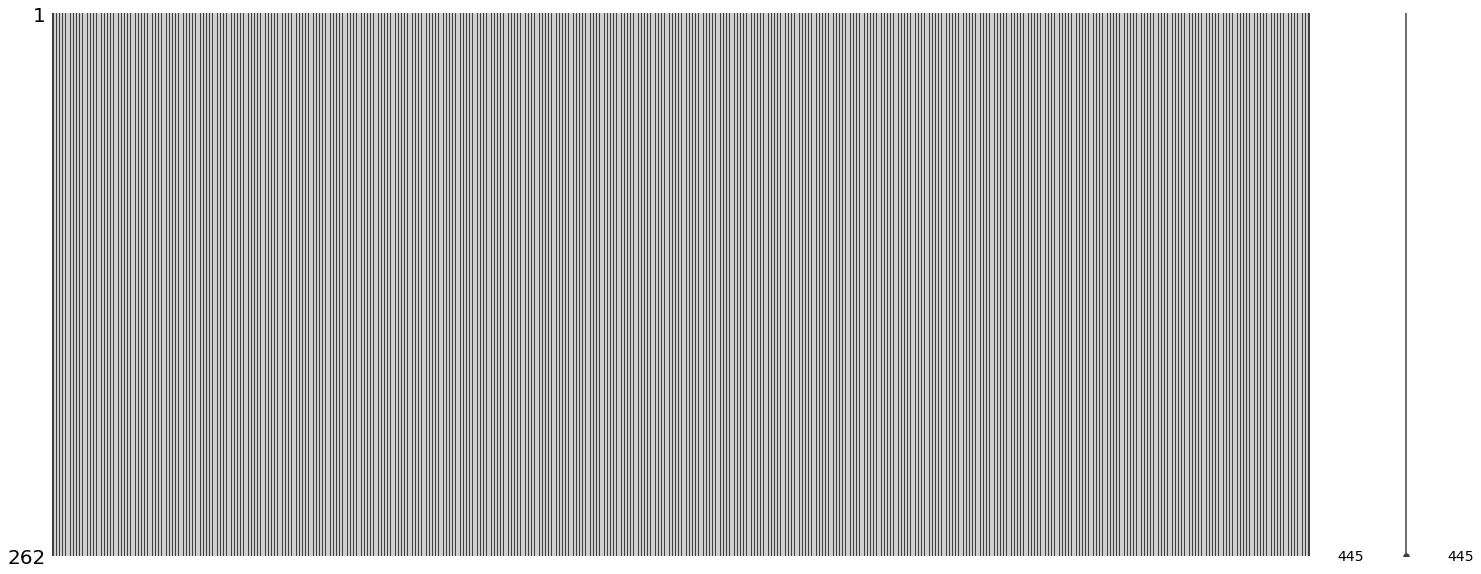

In [4]:
# interpolating each missing values as the arithmetic mean of its preceeding and following values
df_new = df.interpolate(method ='linear', limit_direction ='both') 
msno.matrix(df_new)

### 1.2- Combining the data into a single array

Lets now load the categorical variables and combine the two sets of data into one array.

In [5]:
# loading the categorical variables and saving them in a numpy array
categorical_file = 'data/categorical.csv'
categorical = np.genfromtxt(categorical_file, delimiter=',')[1:,1:]
print('shape of the categorical array:', categorical.shape)

shape of the categorical array: (262, 2)


In [45]:
# converting the pandas dataframe into a numpy array for processing
trends = df_new.values

# combining the two sets of data (trends + categorical) into one array
dataset = np.concatenate((trends, categorical), axis=1)[:, 1:].astype(float)

# printing the dimensions of the arrays
print('shape of trends array:', trends.shape)
print('shape of categorical array:', categorical.shape)
print('-----------------------------------------')
print('shape of the dataset:', dataset.shape)

shape of trends array: (262, 445)
shape of categorical array: (262, 2)
-----------------------------------------
shape of the dataset: (262, 446)


### 1.3- Data distribution

We now plot the data to observe how the data is distributed. This step will help us decide if normalizing/scaling the data is neccessary to achieve better model performance.

mean: 12.603533705492417
standard deviation: 2.2625192564066334
max: 46.46974464
min: 0.45425786
# of elements <$1 107
# of elements <$10: 6303
# of elements <$100: 116328


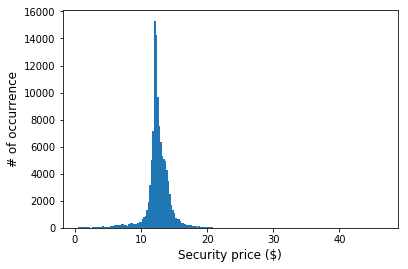

In [7]:
# flattening the data for easier processing
trends_flat = dataset[:, :dataset.shape[1]-2].flatten()
    
# printing a few stats about security prices
mu = trends_flat.mean()
sigma = trends_flat.std()
print('mean:', mu)
print('standard deviation:', sigma)
print('max:', trends_flat.max())
print('min:', trends_flat.min())
print('# of elements <$1', (trends_flat < 1).sum())
print('# of elements <$10:', (trends_flat<10).sum())
print('# of elements <$100:', (trends_flat<100).sum())

# plotting the distributions
plt.hist(trends_flat, bins=200)
plt.ylabel('# of occurrence', fontsize=12)
plt.xlabel('Security price ($)', fontsize=12)
plt.show()

Notice that most security prices hover around 13 dollars in value with a standard deviation of 2 dollars. Although that the data is normally distributed and takes on a similar range of values (ie. on the same order of magnitude), I suggest normalizing the data to a standard normal distribution (zero mean, unit standard deviation) to speed up the learning process. Also of interest is the categorical variables, which take on values 1-7. At this point, I am not sure I will use these categorical variables in model or not, but having the data normalized makes it easier for integration of other streams of data (possibly beyond this categorical data provided) in the future.

Before normalizing the data, lets plot the trends of a few securities to get a better understanding of how security prices fluctuate.

In [8]:
def plot_security(dataset, security_index):
    '''
    Plots the trends of securities passed in to the function
    
    Arguments:
    dataset -- numpy array of the universe of securities
    security_index -- array of integegers indicating the index of securities to plot
    '''
    # setting the colors of each plot
    colors = ['b', 'r', 'g', 'c', 'm', 'k', 'y']
    
    # looping throug the securitiy index to plot each security
    for i in range(len(security_index)):
        plt.plot(dataset[:, security_index[i]], c=colors[i], label='x_'+str(security_index[i]))
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Security price ($)', fontsize=12)
    plt.legend(loc=0)
    plt.show()

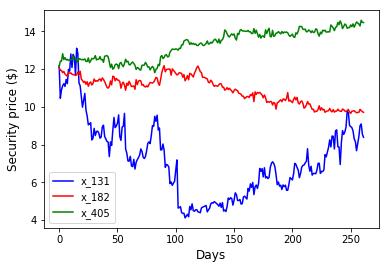

In [9]:
num_sec = 3
rand_sec = np.random.randint(0, trends.shape[1] - 2, num_sec)
plot_security(dataset, rand_sec)

Observe that some securities follow a linear trend, some exhibits seasonal fluctuations, and some follow a more random pattern.

Lets now scale the data to normal distribution with values ranging around zero. This will speed up the learning process and leads to better model performance. We need to reverse scale model predictions after we run model.

In [10]:
def scale(data, feature_range):
    '''
    Scales the values in each column of the dataset to the given range passed in. Columns are scaled independtly
    
    Arguments:
    data -- 2D numpy array of the shape (m, n_features)
    feature_range -- tuple of the form (float, float), indicating the lower and upper bound to scales the values to
    
    Returns:
    data_scaled -- 2D numpy array of the same shape as dataset with each column scaled to the feature_range
    stats -- tuple of the form (min of each column, max of each column, feature_range, scale) to be used in reverse scaling
    '''
    # extracting some useful variables
    lower = feature_range[0]
    upper = feature_range[1]
    data_max = data.max(axis=0)
    data_min = data.min(axis=0)
    
    # computing the scale and saving useful variables into a 'cache' for downstream inverse scaling
    scale = (upper - lower) / (data_max - data_min)
    stats = (data_min, data_max, feature_range, scale)

    # sclaing the data
    data_scaled = scale * data + lower - data_min * scale
    return data_scaled, stats


def inverse_scale(data_scaled, stats):
    '''
    Inversely scaling the dataset back to its original scale using the stats parameter passed in. 
    Each column is scaled independently.
    
    Arguments:
    data_scaled -- 2D numpy array of shape (m, n_features) containing the scaled data
    stats -- tuple of the form (min of columns in orginal data, max of columns in original data, feature_range, scale)
    
    Returns:
    data -- inverserly scaled data
    '''
    # extracting some useful variables from stats
    lower = stats[2][0]
    scale = stats[-1][:-2]
    data_min = stats[0][:-2]
    
    # inverse scaling the data
    data = ((data_scaled - lower) / scale) + data_min
    return data

In [54]:
# defining a feature range and scaling the dataset into a (0, 1) range
feature_range = (0, 1)
dataset_scaled, stats = scale(dataset, feature_range)

number of elements in the scaled dataset: 116328
number of elements in the unscaled dataset: 116328


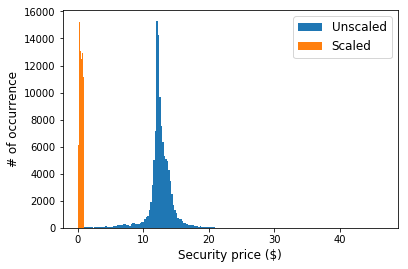

In [55]:
# flattening the scaled dataset for faster plotting
trends_scaled_flat = dataset_scaled[:, :dataset_scaled.shape[1]-2].flatten()

# printing a few stats of the scaled dataset
print('number of elements in the scaled dataset:', len(trends_scaled_flat))
print('number of elements in the unscaled dataset:', len(trends_flat))


# plotting the distribution of the scaled dataset compared to the unscaled version
plt.hist(trends_flat, bins=200, label='Unscaled')
plt.hist(trends_scaled_flat, bins=10, label='Scaled')
plt.ylabel('# of occurrence', fontsize=12)
plt.xlabel('Security price ($)', fontsize=12)
plt.legend(loc=0, fontsize=12)
plt.show()

### 1.4- Spliting the dataset into training and validation sets

Now we need to split the dataset into training and validation sets. The purpose of the training set is to train the model on. The validation set will be used for hyperparameter tuning. The two functions below achieve this goal. `split_data` splits the entire dataset into training and validation sets. Then each of training and validation sets will be passed in to `create_dataset` to create (example, label) dataset that will be directly used in the model for training or validation purposes.

In [56]:
def split_data(dataset, split_ratio):
    '''
    Given a dataset, splits the dataset into training and validation sets, so that split_ratio of the dataset will be
    allocated as the training set and (1 - split_ratio) of the dataset will be the validation set.
    
    Arguments:
    dataset -- 2D numpy array representing the dataset 
    split_ratio -- a float between 0 and 1 that indicates the ratio of the training set in the entire dataset
    
    Return:
    train -- 2D numpy array representing the training portion of the dataset
    valid -- 2D numpy array representing the validation portion of the dataset
    '''
    # finding the index at which the dataset needs to be split
    split_index = int(dataset.shape[0] * split_ratio)
    
    # creating training as what comes before the split index and validation set as what comes after the index
    train = dataset[:split_index, :]
    valid = dataset[split_index:, :]
    
    return train, valid


def create_dataset(dataset, Tx):
    '''
    Given a dataset, creates (X, y) pairings for training/validation/test purposes. Each example X will be Tx time steps. 
    
    Arguments:
    dataset -- 2D numpy array representing training/validation/test portion of the dataset
    Tx -- number of timesteps of each training example X
    
    Returns:
    X -- a numpy array of training/validation/test examples. Each example, X[i], has Tx timesteps
    y -- a numppy array of training/validation/test labels. Each labels, y[i], has 1 timestep
    '''
    # creating empty list to append examples and labels to
    X, y = [], []
    
    # looping through the dataset to create (example, label) pairings
    for i in range(len(dataset) - Tx):
        X.append(dataset[i:i + Tx, :])
        y.append(dataset[i + Tx, :-2])
    
    # converting list to numppy arrays
    X = np.array(X)
    y = np.array(y)
    #y = y.reshape((1, y.shape[0], y.shape[1]))
    
    return X, y

In [57]:
# setting a few hyperparameters of the model. These can be tuned for optimized model performance
train_ratio = 0.8
Tx = 10

In [58]:
# lets split the dataset into training and validation sets
train, valid = split_data(dataset_scaled, train_ratio)

# printing the dimensions of the training and validation sets as a santity check
print('train shape:', train.shape)
print('valid shape:', valid.shape)
print('dataset shape:', dataset.shape)

train shape: (209, 446)
valid shape: (53, 446)
dataset shape: (262, 446)


In [59]:
# lets create (example, label) pairing out of the training and validation sets
x_train, y_train = create_dataset(train, Tx)
x_valid, y_valid = create_dataset(valid, Tx)

# printing the dimensions of (X, y) pairings as a sanity check
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print()
print('x_valid shape:', x_valid.shape)
print('y_valid shape:', y_valid.shape)

x_train shape: (199, 10, 446)
y_train shape: (199, 444)

x_valid shape: (43, 10, 446)
y_valid shape: (43, 444)


We now have the following in the training set (and their corresponding counterparts for the validation set):
- **x_train**: a numpy array of shape (m, Tx, n_feature). We have *m* training examples, each of which is a snippet of *Tx* days worth of security price data. On each day, the input is a *n_feature* dimensional vector, where each entry corresponds to a security price on that particular day.
- **y_train**: a numpy array of shape (Ty, m, n_label). This is essentially the same as x_train that is reshaped to better fit into the LSTM downstream. We have m labels, each of which has Ty timesteps. In this case $T_y=1$ as we are interested in predicting the price of a security on a particular day given the price of that security on Tx previous days. At each timestep, output is a n_label dimensional array, where each entry corresponds to the price of a particular security. 

## 2- Model development

In this section, we are interested to build a machine learning model to learn security price patterns on the training set. We will then use the validation set to tune hyperparameters used in the model. Specifically, we will perform the following tasks:

1. **First model**: develop a model and fit the model on the training set
    - compile the model to get an initial understanding of its performance, bias/variance
2. **Model Optimizaion**: tune the hyperparameters of the model to get better performance
    - we may need to adjust model architecture 

### 2.1- First model

Lets use a Recurrent Neural Network (RNN) to learn patterns of security prices. RNN seems a good choice for this type of problem because of the time series nature of the data. Each unit of the RNN is picked to be a Long-Short Term Memory (LSTM) unit. This is because LSTMs are specially designed to learn long-range dependencies. 
<img src="images/architechture.png">
The performance of neural networks usually correlates with the amount of data at hand. The data in this problem is on the lower side of the spectrum, and hence deeper model are not a good netwrok architecture to start with as they are prone to overfit in such cases. A dropout layer is also included to avoid overfitting. The building blcok is inspired by [this Kaggle blog post](https://www.kaggle.com/amarpreetsingh/stock-prediction-lstm-using-keras/notebook) and many others. 

In [60]:
def rnn_model(n_a, Tx, n_feature, drop, n_label):
    '''
    Implements a RNN network with LSTM units as depicted in the figure above using Keras (Tensorflow backend). 
    
    Arguments:
    n_a -- integer, indicating the dimensionality of the LSTM hidden state
    Tx -- integer, indicating the number of timesteps of the sequence model
    n_feature -- integer, indicating the number of features to predict based on (# securities + # categorical variables)
    drop -- floating point between 0 and 1, indicating the dropout rate. 
    n_label -- integer, indicating number of labels to predict
    
    Return:
    model -- a Keras model object pointing to the LSTM RNN model
    '''
    # defining the model as a sequential type in Keras, adding layer objects one at a time
    model = Sequential()
    model.add(LSTM(n_a, input_shape=(Tx, n_feature)))
    model.add(Dropout(drop))
    model.add(Dense(n_label))

    return model


def compile_run_model(x_train, y_train, x_valid, y_valid, n_a, drop, learning_rate, batch_size, epoch):
    '''
    Compiles and fits the model on the training set (x_train & y_train). Validates on the validation set (x_valid & y_valid)
    
    Arguments:
    x_train --numpy array of shape (m_train, Tx, n_feature) containing the training examples
    y_train -- numpy array of shape (Ty, m, n_laebl) containing the training labels
    x_valid -- numpy array of shape (m_valid, Tx, n_features) containing the validation examples
    y_valid -- numpy array of shape (Ty, m_valid, n_labels) containing the validation labels
    n_a -- dimensionality of the LSTM hidden state
    drop -- dropout rate. A floating point between 0 and 1
    learning_rate -- learning rate of the optimization algorithm
    batch_size -- number of training examples in each batch
    epoch -- number of epochs to train the model on (each epoch is one complete pass through the dataset)
    
    Return:
    history -- Keras object containing the history of the model errors over training epochs
    '''
    # extracting some useful variables from the training set
    m, Tx, n_features = x_train.shape
    _, n_labels = y_train.shape
    
    # instantiating an object of the RNN model
    model = rnn_model(n_a, Tx, n_features, drop, n_labels)
    
    # defining an optimizer
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    # compiling the model
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mape'])
    
    # fitting the model to the training dataset, validating on the validation set
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_data=(x_valid, y_valid))
    
    return model, history

Lets now assign initial values to the hyperparameters of the model and get an understanding of its performance. These values are mostly based on my intuition and experience.

In [61]:
# hyperparameter assignment
m, Tx, n_features = x_train.shape
_, n_labels = y_train.shape
n_a = n_labels
learning_rate = 0.01
batch_size = 16
drop= 0.2
epoch = 100

In [62]:
# call compile_run_model to build, compile, and fit the model to the training set
model, history = compile_run_model(x_train, y_train, x_valid, y_valid, n_a, drop, learning_rate, batch_size, epoch)

Train on 199 samples, validate on 43 samples
Epoch 1/100
199/199 [==============================] - 4s 20ms/step - loss: 0.2031 - mean_absolute_percentage_error: 1679347.2286 - val_loss: 0.1675 - val_mean_absolute_percentage_error: 1553258.0116
Epoch 2/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0455 - mean_absolute_percentage_error: 1131070.5590 - val_loss: 0.0973 - val_mean_absolute_percentage_error: 1474806.7878
Epoch 3/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0266 - mean_absolute_percentage_error: 1021136.3389 - val_loss: 0.0818 - val_mean_absolute_percentage_error: 1567445.0494
Epoch 4/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0209 - mean_absolute_percentage_error: 841806.0115 - val_loss: 0.0630 - val_mean_absolute_percentage_error: 1599848.8430
Epoch 5/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0190 - mean_absolute_percentage_error: 943925.8723 - val_loss: 0.0580 - val_me

Epoch 42/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0082 - mean_absolute_percentage_error: 642531.9862 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 809616.3721
Epoch 43/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0084 - mean_absolute_percentage_error: 623981.2235 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 763511.9506
Epoch 44/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0075 - mean_absolute_percentage_error: 618233.9406 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 816688.9317
Epoch 45/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0080 - mean_absolute_percentage_error: 618799.6168 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 724070.2776
Epoch 46/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0074 - mean_absolute_percentage_error: 672698.4918 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 741194.2224
Epoch

199/199 [==============================] - 2s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 586334.2952 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 781616.9273
Epoch 84/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0070 - mean_absolute_percentage_error: 562028.6972 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 806027.9855
Epoch 85/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0071 - mean_absolute_percentage_error: 594762.0791 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 806473.6628
Epoch 86/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0068 - mean_absolute_percentage_error: 557822.2023 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 714246.1250
Epoch 87/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0070 - mean_absolute_percentage_error: 582470.2657 - val_loss: 0.0188 - val_mean_absolute_percentage_error: 817335.9477
Epoch 88/100
199/1

Lets now plot the training and validation costs as a function of epochs to see the model learn security price trends.

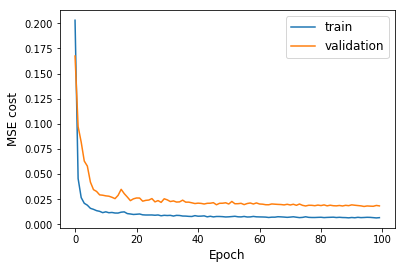

In [63]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend(loc=0, fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE cost', fontsize=12)
plt.show()

In [65]:
def model_predict(model):
    '''
    Computes the prediction of the given model on training and validation sets
    
    Argument:
    model -- keras object containing the model parameters
    
    Returns:
    train_pred -- numpy array of shape (m_train, n_features), containing the predictions of the model on the training set
    valid_pred -- numpy array of shape (m_valid, n_features), containingthe predictions of the model on the validation set
    '''
    # using the trained model to make predictions on the training and validation sets
    train_pred = model.predict(x_train)
    valid_pred = model.predict(x_valid)
    
    return train_pred, valid_pred
    

def model_cost(model):
    '''
    Given the predictions of the model on the training and validation set, it computes the root mean squared (RMS)
    cost of the model.
    
    Argument:
    model -- keras object containing the model parameters
    
    Returns:
    train_rms -- float, indicating the RMS cost of the model on the training set 
    valid_rms -- float, indicating the RMS cost of the model on the validation set
    '''
    # computing the predictions of the model on the training and validation sets
    train_pred, valid_pred = model_predict(model)
    
    # computing root mean square error as a measure of prediciton performance on the training and validation sets
    train_rms = np.sqrt(np.mean(np.power((y_train - train_pred), 2)))
    valid_rms = np.sqrt(np.mean(np.power((y_valid - valid_pred), 2)))
    
    return train_rms, valid_rms

In [66]:
train_rms, valid_rms = model_cost(model)

# comparing the training and validation errors can help identify bias/variance of the model
print('training RMS error:', train_rms)
print('validation RMS error:', valid_rms)

training RMS error: 0.06578006444764019
validation RMS error: 0.1354156999975079


We have RMS error of ~0.7 on the training set and ~0.14 on the validation set. These values can differ from run to run as the weights of the model are intialized randomly and may end up at slightly different values. I ran the model a few times and observed the RMS cost to be around the values stated above. To decide whether this is more of a bias problem or variance problem, we need an estimate of Bayes error (minimum achievable error). Bayes error tells how much better we can expect the algorithm to do on the training set. In other words, the difference between the Bayes error and training error gives an indication of the bias problem. Similarly, the difference between the training error and validation error gives an indication of variance problem. The relative magnitude of these two helps us decide where we need to focus our efforts (reducing bias vs. reducing variance). 

Finding an estimate of Bayes error on security price prediciton is a difficult task. However, we know that it is is most possibly greater than zero. As such, it looks like the above model has a bigger variance problem than bias (ie. it has harder time generalizing to an unseen test set). Hence we first explore avenues for variance reduction (eg. regularization).

### 2.2- Model optimization

In this section, we tune our model hyperparameters to reduce bias and variance of the model. 

In [67]:
def optimize_epoch(epochs):
    '''
    Given a list of epochs values, compiles and runs the model. Other hyperparameters of the model will be kept unchanged.
    
    Arguments:
    epochs -- a list of integers, indicating the number of epochs to train the model for
    
    Returns:
    epoch_models -- a list of tuples of the form (model, history) associated with the corresponding epoch value.
    '''
    # creating an empty list to hold models and histories
    epoch_models = []
    
    # looping through the list of epoch values
    for i in range(len(epochs)):
        model, history = compile_run_model(x_train, y_train, x_valid, y_valid, n_a, drop, learning_rate, batch_size, epochs[i])
        epoch_models.append((model, history))
        
    return epoch_models


def optimize_dropout(dropouts):
    '''
    Given a list of dropout values, compiles and runs the model. Other hyperparameters of the model will be kept unchanged.
    
    Argument:
    dropouts -- a list of dropout values. Each entry is a float between 0 and 1, indicating the dropout level of the model.
    
    Returns:
    dropout_models -- a list of tuples of the from (model, history) associated with the corresponding dropout rate.
    '''
    # creating an empty list to hold models and histories
    dropout_models = []
    
    # looping through the list of dropout values
    for i in range(len(dropouts)):
        model, history = compile_run_model(x_train, y_train, x_valid, y_valid, n_a, dropouts[i], learning_rate, batch_size, epoch)
        dropout_models.append((model, history))
    
    return dropout_models


def optimize_lr(rates):
    '''
    Given a list of learning rates, compiles and runs the model. Other hyperparameters of the model will be kept unchanged.
    
    Argument:
    rates -- a list of floats indicating the learning rate associated with the model
    
    Returns:
    lr_models -- a list of tuples of the form (model, history), associated with the corresponding learning rate
    '''
    # creating an empty list to hold models and histories
    lr_models = []
    
    # looping through the list of learning rate values
    for i in range(len(rates)):
        model, history = compile_run_model(x_train, y_train, x_valid, y_valid, n_a, drop, rates[i], batch_size, epoch)
        lr_models.append((model, history))
    
    return lr_models


def optimize_batch_size(batches):
    '''
    Given a list of batch sizes, compiles nad runs the model. Other hyperparameters of the model will be kept unchanged.
    
    Argument:
    batches -- a list of integers. Each entry indicates the batch size
    
    Returns:
    batch_models -- a list of tuples of the form (model, history), associated with corresponding batch sizes
    '''
    # creating an empty list to hold models and histories
    batch_models = []
    
    # looping through the list batch sizes
    for i in range(len(batches)):
        model, history = compile_run_model(x_train, y_train, x_valid, y_valid, n_a, drop, learning_rate, batches[i], epoch)
        batch_models.append((model, history))
    
    return batch_models

We now write a function to easily plot and compare the cost associated with each of the hyperparameters being tuned above. 

In [93]:
def plot_hpram_cost(models, hpram, values):
    '''
    Plots the cost of the learning model associated with each of the hyperparameters passed in. The plots are optimized
    to test four values of hyperparameters
    
    Arguments:
    models -- a tuple of the form (model, history), where model and history are keras objects containing the model
    hpram -- string, indicating the hyperparameters being optimized
    values -- a list of floats, indicating the values of the optimizing hyperparameters tested
    '''
    # initializing subplots
    fig, ax = plt.subplots(1, len(values), figsize=(15, 5) , sharey=True)

    # looping through the models
    for i in range(len(values)):
        # computing the RMS cost associated with the model
        train_cost, valid_cost = model_cost(models[i][0])
        
        # plotting the model cost as a function of epoch
        ax[i].plot(models[i][1].history['loss'], label='train')
        ax[i].plot(models[i][1].history['val_loss'], label='validation')
        ax[i].set_title(hpram + ': ' + str(values[i]), fontsize=16)
        ax[i].set_xlabel('Epoch', fontsize=14)
        ax[i].text(0.2, -0.2, 'training cost: ' + str(round(train_cost, 2)), transform=ax[i].transAxes, fontsize=12)
        ax[i].text(0.2, -0.27, 'validation cost: ' + str(round(valid_cost, 2)), transform=ax[i].transAxes, fontsize=12)

        if i == 0:
            ax[i].set_ylabel('MSE cost', fontsize=14)
            ax[i].legend(loc=0, fontsize=14)

We know start tuning the dropout rate to reduce the variance of the model.

In [69]:
# lets observe the following models' performances
dropouts = [0.1, 0.3, 0.5, 0.8]
models_drop = optimize_dropout(dropouts)

Train on 199 samples, validate on 43 samples
Epoch 1/100
199/199 [==============================] - 4s 20ms/step - loss: 0.2351 - mean_absolute_percentage_error: 1536913.5919 - val_loss: 0.1685 - val_mean_absolute_percentage_error: 1744895.7384
Epoch 2/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0491 - mean_absolute_percentage_error: 1421893.3128 - val_loss: 0.1146 - val_mean_absolute_percentage_error: 1528095.4390
Epoch 3/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0296 - mean_absolute_percentage_error: 1075039.2318 - val_loss: 0.0872 - val_mean_absolute_percentage_error: 1389739.3924
Epoch 4/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0227 - mean_absolute_percentage_error: 1054594.5349 - val_loss: 0.0646 - val_mean_absolute_percentage_error: 1265292.2936
Epoch 5/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0196 - mean_absolute_percentage_error: 981866.3657 - val_loss: 0.0627 - val_m

Epoch 42/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0074 - mean_absolute_percentage_error: 537163.6102 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 955194.7951
Epoch 43/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0073 - mean_absolute_percentage_error: 637411.1881 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 885371.4593
Epoch 44/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0077 - mean_absolute_percentage_error: 670068.7129 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 846933.6483
Epoch 45/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0073 - mean_absolute_percentage_error: 574420.5472 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 867249.0712
Epoch 46/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0071 - mean_absolute_percentage_error: 615172.0459 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 899887.7631
Epoch

199/199 [==============================] - 2s 10ms/step - loss: 0.0059 - mean_absolute_percentage_error: 514071.8547 - val_loss: 0.0235 - val_mean_absolute_percentage_error: 797934.5102
Epoch 84/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0062 - mean_absolute_percentage_error: 564089.5723 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 788398.9041
Epoch 85/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0060 - mean_absolute_percentage_error: 532297.6988 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 806399.9637
Epoch 86/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0060 - mean_absolute_percentage_error: 590376.9761 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 793026.8387
Epoch 87/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0062 - mean_absolute_percentage_error: 588657.7943 - val_loss: 0.0247 - val_mean_absolute_percentage_error: 769067.2456
Epoch 88/100
199/1

Epoch 24/100
199/199 [==============================] - 2s 12ms/step - loss: 0.0113 - mean_absolute_percentage_error: 706863.2726 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 996562.5756
Epoch 25/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0117 - mean_absolute_percentage_error: 700406.6011 - val_loss: 0.0331 - val_mean_absolute_percentage_error: 993427.2413
Epoch 26/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0117 - mean_absolute_percentage_error: 715858.5809 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 982745.3140
Epoch 27/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0114 - mean_absolute_percentage_error: 731119.4422 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 1001061.0058
Epoch 28/100
199/199 [==============================] - 2s 12ms/step - loss: 0.0106 - mean_absolute_percentage_error: 703470.5605 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 975679.8590
Epoc

199/199 [==============================] - 2s 10ms/step - loss: 0.0090 - mean_absolute_percentage_error: 631227.8224 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 928506.2398
Epoch 66/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0089 - mean_absolute_percentage_error: 644882.6806 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 905602.0567
Epoch 67/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0090 - mean_absolute_percentage_error: 644570.8783 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 900221.7311
Epoch 68/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0089 - mean_absolute_percentage_error: 632447.7412 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 904801.6701
Epoch 69/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0090 - mean_absolute_percentage_error: 668510.6316 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 865161.2747
Epoch 70/100
199/1

Epoch 6/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0262 - mean_absolute_percentage_error: 837012.7852 - val_loss: 0.0749 - val_mean_absolute_percentage_error: 1170547.8808
Epoch 7/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0256 - mean_absolute_percentage_error: 809974.0424 - val_loss: 0.0523 - val_mean_absolute_percentage_error: 1241056.8866
Epoch 8/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0242 - mean_absolute_percentage_error: 849159.0553 - val_loss: 0.0393 - val_mean_absolute_percentage_error: 1177815.9593
Epoch 9/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0237 - mean_absolute_percentage_error: 805005.4876 - val_loss: 0.0422 - val_mean_absolute_percentage_error: 1164437.9215
Epoch 10/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0205 - mean_absolute_percentage_error: 803729.5641 - val_loss: 0.0376 - val_mean_absolute_percentage_error: 1201388.9215
Epoc

Epoch 47/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0129 - mean_absolute_percentage_error: 792386.1921 - val_loss: 0.0345 - val_mean_absolute_percentage_error: 1093369.1221
Epoch 48/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0123 - mean_absolute_percentage_error: 768990.2280 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 1091354.9419
Epoch 49/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0126 - mean_absolute_percentage_error: 680723.3222 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 1072268.9390
Epoch 50/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0114 - mean_absolute_percentage_error: 759497.9532 - val_loss: 0.0301 - val_mean_absolute_percentage_error: 1022952.2878
Epoch 51/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0125 - mean_absolute_percentage_error: 671015.3882 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 1044506.4273


199/199 [==============================] - 2s 11ms/step - loss: 0.0111 - mean_absolute_percentage_error: 865185.2971 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 974617.8227
Epoch 89/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0104 - mean_absolute_percentage_error: 774917.4774 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 998091.0552
Epoch 90/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0107 - mean_absolute_percentage_error: 868378.3759 - val_loss: 0.0296 - val_mean_absolute_percentage_error: 990991.9971
Epoch 91/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0112 - mean_absolute_percentage_error: 840186.8668 - val_loss: 0.0325 - val_mean_absolute_percentage_error: 989613.8169
Epoch 92/100
199/199 [==============================] - 2s 11ms/step - loss: 0.0110 - mean_absolute_percentage_error: 730724.5090 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 1007273.2006
Epoch 93/100
199/

Epoch 29/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0276 - mean_absolute_percentage_error: 1195967.1332 - val_loss: 0.0863 - val_mean_absolute_percentage_error: 1293415.9564
Epoch 30/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0301 - mean_absolute_percentage_error: 1351403.1187 - val_loss: 0.0833 - val_mean_absolute_percentage_error: 1282714.4099
Epoch 31/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0282 - mean_absolute_percentage_error: 1316669.9512 - val_loss: 0.0813 - val_mean_absolute_percentage_error: 1283463.0901
Epoch 32/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0302 - mean_absolute_percentage_error: 1412148.7434 - val_loss: 0.0851 - val_mean_absolute_percentage_error: 1309393.5378
Epoch 33/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0271 - mean_absolute_percentage_error: 1191379.1546 - val_loss: 0.0782 - val_mean_absolute_percentage_error: 1276878.

Epoch 70/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0273 - mean_absolute_percentage_error: 1257916.0261 - val_loss: 0.0819 - val_mean_absolute_percentage_error: 1290555.8314
Epoch 71/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0286 - mean_absolute_percentage_error: 1105090.4995 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 1305972.2413
Epoch 72/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0278 - mean_absolute_percentage_error: 1270039.3505 - val_loss: 0.0817 - val_mean_absolute_percentage_error: 1293804.4738
Epoch 73/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0270 - mean_absolute_percentage_error: 1273251.8536 - val_loss: 0.0802 - val_mean_absolute_percentage_error: 1288455.0320
Epoch 74/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0291 - mean_absolute_percentage_error: 1120397.7827 - val_loss: 0.0829 - val_mean_absolute_percentage_error: 1297533.

Lets plots the cost of the four models and compare their performance on the training and validation sets.

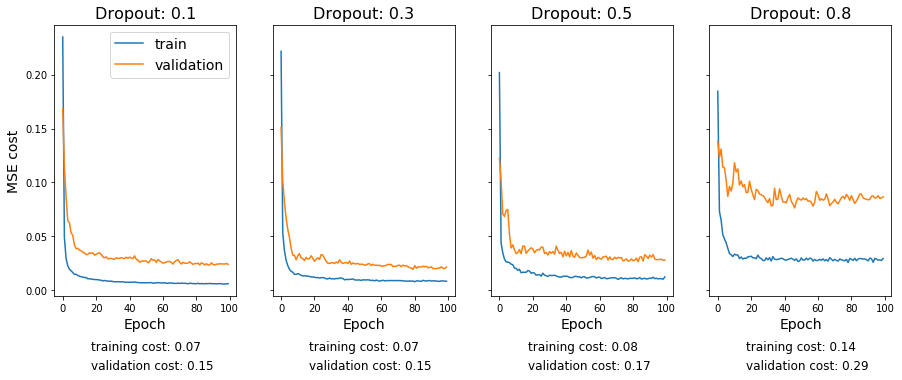

In [70]:
plot_hpram_cost(models_drop, 'Dropout', dropouts)

From the figures above, note that the models with dropout rates of 0.1 and 0.3 have the best model performance in terms of RMS cost. The model with `dropout = 0.2` above outperformed the four models here. This model has the lowest variance: has the smallest generalization error as the difference between the validation and training costs. We set the dropout rate to 0.2

In [71]:
drop = 0.2

Now lets optimize the number of epochs to train the model on. Early stopping is another way to reduce overfitting. Training the model for too many iterations does not neccessarily result in better test performance. This prones the model to fitting the training set "too well" that it has hard times generalizing to new data sets. Hence, we may decide to let go of some training set performance to get a better test set performance.

In [72]:
epochs = [50, 100, 200, 300]
models_epoch = optimize_epoch(epochs)

Train on 199 samples, validate on 43 samples
Epoch 1/50
199/199 [==============================] - 5s 23ms/step - loss: 0.2896 - mean_absolute_percentage_error: 2099682.9742 - val_loss: 0.2039 - val_mean_absolute_percentage_error: 1475718.5145
Epoch 2/50
199/199 [==============================] - 2s 10ms/step - loss: 0.0603 - mean_absolute_percentage_error: 1537185.1498 - val_loss: 0.1331 - val_mean_absolute_percentage_error: 1497979.1337
Epoch 3/50
199/199 [==============================] - 2s 12ms/step - loss: 0.0406 - mean_absolute_percentage_error: 1260667.0923 - val_loss: 0.1105 - val_mean_absolute_percentage_error: 1529111.7762
Epoch 4/50
199/199 [==============================] - 2s 12ms/step - loss: 0.0294 - mean_absolute_percentage_error: 1210348.9906 - val_loss: 0.0857 - val_mean_absolute_percentage_error: 1340307.0523
Epoch 5/50
199/199 [==============================] - 2s 10ms/step - loss: 0.0241 - mean_absolute_percentage_error: 991235.5658 - val_loss: 0.0785 - val_mean_a

Epoch 42/50
199/199 [==============================] - 2s 11ms/step - loss: 0.0095 - mean_absolute_percentage_error: 658628.8918 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 986045.5756
Epoch 43/50
199/199 [==============================] - 2s 11ms/step - loss: 0.0096 - mean_absolute_percentage_error: 659473.3222 - val_loss: 0.0351 - val_mean_absolute_percentage_error: 949382.8459
Epoch 44/50
199/199 [==============================] - 2s 11ms/step - loss: 0.0091 - mean_absolute_percentage_error: 675630.0165 - val_loss: 0.0327 - val_mean_absolute_percentage_error: 1025881.3663
Epoch 45/50
199/199 [==============================] - 2s 11ms/step - loss: 0.0089 - mean_absolute_percentage_error: 616087.0586 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 980715.9884
Epoch 46/50
199/199 [==============================] - 2s 11ms/step - loss: 0.0088 - mean_absolute_percentage_error: 703363.4658 - val_loss: 0.0315 - val_mean_absolute_percentage_error: 1011668.4360
Epoch 47

Epoch 33/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0092 - mean_absolute_percentage_error: 615356.1391 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 973780.0523
Epoch 34/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0091 - mean_absolute_percentage_error: 708310.0398 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 993506.2006
Epoch 35/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0100 - mean_absolute_percentage_error: 700228.6201 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 1013031.6773
Epoch 36/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0096 - mean_absolute_percentage_error: 555255.2604 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 1008064.3023
Epoch 37/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0092 - mean_absolute_percentage_error: 679771.9315 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 946105.1744
Epo

199/199 [==============================] - 2s 10ms/step - loss: 0.0082 - mean_absolute_percentage_error: 557702.8546 - val_loss: 0.0276 - val_mean_absolute_percentage_error: 1014359.9564
Epoch 75/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0083 - mean_absolute_percentage_error: 582094.3112 - val_loss: 0.0289 - val_mean_absolute_percentage_error: 999205.4099
Epoch 76/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0078 - mean_absolute_percentage_error: 658426.6002 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 952302.3052
Epoch 77/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0074 - mean_absolute_percentage_error: 641541.1891 - val_loss: 0.0280 - val_mean_absolute_percentage_error: 986985.0436
Epoch 78/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0079 - mean_absolute_percentage_error: 609932.4749 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 992249.2064
Epoch 79/100
199/

Epoch 15/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0107 - mean_absolute_percentage_error: 708552.6080 - val_loss: 0.0261 - val_mean_absolute_percentage_error: 1060844.3605
Epoch 16/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0100 - mean_absolute_percentage_error: 694098.4168 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 1059758.6919
Epoch 17/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0110 - mean_absolute_percentage_error: 701349.1715 - val_loss: 0.0303 - val_mean_absolute_percentage_error: 945007.7791
Epoch 18/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0109 - mean_absolute_percentage_error: 705890.7001 - val_loss: 0.0299 - val_mean_absolute_percentage_error: 918034.0640
Epoch 19/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0101 - mean_absolute_percentage_error: 703143.5094 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 973558.2006
Epo

199/199 [==============================] - 2s 10ms/step - loss: 0.0074 - mean_absolute_percentage_error: 615592.1776 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 912164.3619
Epoch 57/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0074 - mean_absolute_percentage_error: 615688.2962 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 945220.8837
Epoch 58/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0075 - mean_absolute_percentage_error: 606321.0355 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 932971.6730
Epoch 59/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0072 - mean_absolute_percentage_error: 608988.6385 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 894099.7020
Epoch 60/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0071 - mean_absolute_percentage_error: 595166.3965 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 917013.7078
Epoch 61/200
199/1

199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 574020.6382 - val_loss: 0.0199 - val_mean_absolute_percentage_error: 900932.7180
Epoch 98/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0072 - mean_absolute_percentage_error: 581162.9501 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 907392.9230
Epoch 99/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0066 - mean_absolute_percentage_error: 591050.9076 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 912771.2529
Epoch 100/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 557482.6709 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 960128.3343
Epoch 101/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 569208.5853 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 879310.3532
Epoch 102/200
19

199/199 [==============================] - 2s 11ms/step - loss: 0.0064 - mean_absolute_percentage_error: 533211.7122 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 863789.0930
Epoch 139/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0063 - mean_absolute_percentage_error: 516735.5693 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 858659.1802
Epoch 140/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0063 - mean_absolute_percentage_error: 550040.7839 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 855853.6148
Epoch 141/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0063 - mean_absolute_percentage_error: 599943.5166 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 823350.9477
Epoch 142/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0063 - mean_absolute_percentage_error: 538817.2648 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 835559.0392
Epoch 143/200


199/199 [==============================] - 2s 10ms/step - loss: 0.0064 - mean_absolute_percentage_error: 569807.8838 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 838121.5567
Epoch 180/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 546486.1044 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 824245.2020
Epoch 181/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0060 - mean_absolute_percentage_error: 515044.5396 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 808803.1584
Epoch 182/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0062 - mean_absolute_percentage_error: 546122.7409 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 824358.2689
Epoch 183/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0061 - mean_absolute_percentage_error: 533860.7900 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 863787.2442
Epoch 184/200


Epoch 20/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0115 - mean_absolute_percentage_error: 741924.9527 - val_loss: 0.0298 - val_mean_absolute_percentage_error: 982485.6308
Epoch 21/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0117 - mean_absolute_percentage_error: 730737.9747 - val_loss: 0.0314 - val_mean_absolute_percentage_error: 1058017.0552
Epoch 22/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0115 - mean_absolute_percentage_error: 738963.5986 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 998665.7907
Epoch 23/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0111 - mean_absolute_percentage_error: 777532.4692 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 987323.0436
Epoch 24/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0104 - mean_absolute_percentage_error: 730700.7812 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 955202.0581
Epoc

199/199 [==============================] - 2s 11ms/step - loss: 0.0087 - mean_absolute_percentage_error: 710948.9752 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 894162.5160
Epoch 62/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0089 - mean_absolute_percentage_error: 670391.2968 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 915923.8590
Epoch 63/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0089 - mean_absolute_percentage_error: 630674.7937 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 908338.1352
Epoch 64/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0086 - mean_absolute_percentage_error: 717892.9598 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 896245.7267
Epoch 65/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0087 - mean_absolute_percentage_error: 634620.6812 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 844546.5174
Epoch 66/300
199/1

199/199 [==============================] - 2s 10ms/step - loss: 0.0077 - mean_absolute_percentage_error: 571635.5264 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 874871.7631
Epoch 103/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0079 - mean_absolute_percentage_error: 605960.1566 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 909071.9782
Epoch 104/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0081 - mean_absolute_percentage_error: 640681.3452 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 813803.4826
Epoch 105/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0079 - mean_absolute_percentage_error: 640237.1894 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 839837.4346
Epoch 106/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0081 - mean_absolute_percentage_error: 633957.4105 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 857815.8358
Epoch 107/300


199/199 [==============================] - 2s 11ms/step - loss: 0.0073 - mean_absolute_percentage_error: 597168.8585 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 857716.3910
Epoch 144/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0072 - mean_absolute_percentage_error: 574500.2410 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 866101.4869
Epoch 145/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0075 - mean_absolute_percentage_error: 589358.7395 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 858876.1279
Epoch 146/300
199/199 [==============================] - 2s 11ms/step - loss: 0.0074 - mean_absolute_percentage_error: 662523.5601 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 867035.3735
Epoch 147/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0066 - mean_absolute_percentage_error: 536524.2434 - val_loss: 0.0201 - val_mean_absolute_percentage_error: 866344.6599
Epoch 148/300


199/199 [==============================] - 2s 10ms/step - loss: 0.0070 - mean_absolute_percentage_error: 582449.6804 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 876222.6657
Epoch 185/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 533550.8697 - val_loss: 0.0203 - val_mean_absolute_percentage_error: 868828.2820
Epoch 186/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0070 - mean_absolute_percentage_error: 606223.4761 - val_loss: 0.0208 - val_mean_absolute_percentage_error: 886392.3198
Epoch 187/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 541790.5631 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 869518.4535
Epoch 188/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0071 - mean_absolute_percentage_error: 531104.9991 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 879876.6860
Epoch 189/300


199/199 [==============================] - 2s 10ms/step - loss: 0.0067 - mean_absolute_percentage_error: 578752.2302 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 878659.3038
Epoch 226/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0072 - mean_absolute_percentage_error: 589396.9971 - val_loss: 0.0211 - val_mean_absolute_percentage_error: 880840.7863
Epoch 227/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0068 - mean_absolute_percentage_error: 549276.1608 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 882307.7049
Epoch 228/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0068 - mean_absolute_percentage_error: 554880.8628 - val_loss: 0.0209 - val_mean_absolute_percentage_error: 872940.8881
Epoch 229/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0069 - mean_absolute_percentage_error: 568751.9463 - val_loss: 0.0204 - val_mean_absolute_percentage_error: 874819.5959
Epoch 230/300


199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 542345.7960 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 844223.4811
Epoch 267/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 589930.5043 - val_loss: 0.0200 - val_mean_absolute_percentage_error: 869720.3634
Epoch 268/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0066 - mean_absolute_percentage_error: 518885.6372 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 873537.2791
Epoch 269/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0064 - mean_absolute_percentage_error: 613490.0930 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 836068.0116
Epoch 270/300
199/199 [==============================] - 2s 10ms/step - loss: 0.0065 - mean_absolute_percentage_error: 620822.0292 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 862528.3663
Epoch 271/300


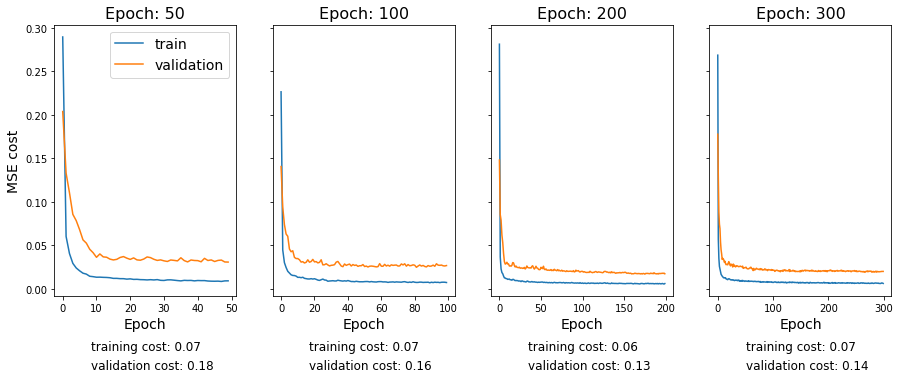

In [73]:
plot_hpram_cost(models_epoch, 'Epoch', epochs)

In optimizing the number of epochs to train the model, we need to be careful of over-training the model. This means that the model is trained for many iterations that it fits the training set "too well" and as a results has hard times generalizing to unseen test sets. 

From the figures above, and also taking a closer look at the RMS errors as a function of epoch number (the cell below), it seems that training the model for any more than ~200 iterations causes the model to overfit. Hence we choose to train the model for 200 iterations to obtain the best performance without overfitting.

In [77]:
# this is a sanity check to make sure the model trained for 300 epochs not overfit
model200, model300 = models_epoch[2][1], models_epoch[-1][1]
temp200, temp300 = model200.history['val_loss'], model300.history['val_loss']

# printing the average cost after 100, 200, and 300 training epochs
# the averaging is to get rid of epoch to epoch fluctuations
print('cost after 100 epochs:', round(np.average(temp300[90:110]), 4))
print('cost after 200 epochs:', round(np.average(temp200[190:210]), 4))
print('cost after 300 epochs:', round(np.average(temp300[290:]), 4))

cost after 100 epochs: 0.0215
cost after 200 epochs: 0.0177
cost after 300 epochs: 0.0199


In [83]:
epoch = 200

We now optimize the learning rate through a similar procedure as dropout optimization. I first ran the model with four learning rates [0.1, 0.01, 0.001, 0.0001] for 50 epochs. This was to get an understanding of what the order of magnitude of a good learning rate. It resulted that 0.001 outperformed the rest of the models. Hence the cell below now check finer learning rate values around 0.001, and this time for 200 epoch.

In [84]:
learning_rates = [0.003, 0.001, 0.0003, 0.0001]
models_lr = optimize_lr(learning_rates)

Train on 199 samples, validate on 43 samples
Epoch 1/200
199/199 [==============================] - 6s 29ms/step - loss: 0.0797 - mean_absolute_percentage_error: 1159473.7864 - val_loss: 0.0754 - val_mean_absolute_percentage_error: 1400333.8808
Epoch 2/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0213 - mean_absolute_percentage_error: 839952.7418 - val_loss: 0.0552 - val_mean_absolute_percentage_error: 1375607.4419
Epoch 3/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0157 - mean_absolute_percentage_error: 711776.3477 - val_loss: 0.0373 - val_mean_absolute_percentage_error: 1296412.3459
Epoch 4/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0123 - mean_absolute_percentage_error: 713208.5173 - val_loss: 0.0358 - val_mean_absolute_percentage_error: 1072795.2994
Epoch 5/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0106 - mean_absolute_percentage_error: 691859.1822 - val_loss: 0.0296 - val_mean

Epoch 42/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 517674.3329 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 882021.3706
Epoch 43/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0056 - mean_absolute_percentage_error: 465161.8875 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 894522.9302
Epoch 44/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0058 - mean_absolute_percentage_error: 464443.3109 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 921221.3837
Epoch 45/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0058 - mean_absolute_percentage_error: 474233.1517 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 876883.4913
Epoch 46/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0059 - mean_absolute_percentage_error: 498345.8642 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 885798.4142
Epoch

199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 463997.9763 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 853886.3779
Epoch 84/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 422736.3673 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 813930.1846
Epoch 85/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 455482.7547 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 813412.6831
Epoch 86/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 437707.6253 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 772916.5087
Epoch 87/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 457553.1595 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 826404.7762
Epoch 88/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0045 - mean_absolute_percentage_error: 436067.7552 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 777117.2108
Epoch 125/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0047 - mean_absolute_percentage_error: 420955.9673 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 791260.5581
Epoch 126/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0045 - mean_absolute_percentage_error: 436973.9680 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 797895.5509
Epoch 127/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0044 - mean_absolute_percentage_error: 434906.9494 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 802207.3256
Epoch 128/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0044 - mean_absolute_percentage_error: 430370.3843 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 784202.0741
Epoch 129/200


199/199 [==============================] - 2s 11ms/step - loss: 0.0043 - mean_absolute_percentage_error: 400598.8649 - val_loss: 0.0161 - val_mean_absolute_percentage_error: 775699.8953
Epoch 166/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0043 - mean_absolute_percentage_error: 413972.9931 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 779281.9884
Epoch 167/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0042 - mean_absolute_percentage_error: 425863.4359 - val_loss: 0.0163 - val_mean_absolute_percentage_error: 791341.4782
Epoch 168/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0043 - mean_absolute_percentage_error: 446396.6957 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 801453.1105
Epoch 169/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0043 - mean_absolute_percentage_error: 387040.1322 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 802363.6453
Epoch 170/200


Epoch 6/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0130 - mean_absolute_percentage_error: 688960.2546 - val_loss: 0.0320 - val_mean_absolute_percentage_error: 960084.2020
Epoch 7/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0125 - mean_absolute_percentage_error: 684104.0730 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 907245.7398
Epoch 8/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0118 - mean_absolute_percentage_error: 659797.8291 - val_loss: 0.0294 - val_mean_absolute_percentage_error: 931105.2398
Epoch 9/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0113 - mean_absolute_percentage_error: 659443.3169 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 892066.9462
Epoch 10/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0108 - mean_absolute_percentage_error: 659970.8405 - val_loss: 0.0285 - val_mean_absolute_percentage_error: 889879.1424
Epoch 11/

199/199 [==============================] - 2s 11ms/step - loss: 0.0066 - mean_absolute_percentage_error: 547453.3350 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 703635.9971
Epoch 48/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 564468.3797 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 668713.1904
Epoch 49/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 540003.6655 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 705965.3488
Epoch 50/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0066 - mean_absolute_percentage_error: 514804.7242 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 727295.1802
Epoch 51/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 495057.4874 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 729891.3677
Epoch 52/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0059 - mean_absolute_percentage_error: 507810.8119 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 610829.8227
Epoch 89/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0061 - mean_absolute_percentage_error: 497270.5366 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 627979.9797
Epoch 90/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 482175.4377 - val_loss: 0.0166 - val_mean_absolute_percentage_error: 653078.1759
Epoch 91/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 461381.3992 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 620230.8270
Epoch 92/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0056 - mean_absolute_percentage_error: 474869.9362 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 645066.2718
Epoch 93/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0052 - mean_absolute_percentage_error: 470099.5035 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 607677.7151
Epoch 130/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 475690.3863 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 621336.9099
Epoch 131/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 463987.8653 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 632748.0087
Epoch 132/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0052 - mean_absolute_percentage_error: 449694.7921 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 615243.2413
Epoch 133/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 466141.1643 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 625794.2020
Epoch 134/200


199/199 [==============================] - 2s 12ms/step - loss: 0.0050 - mean_absolute_percentage_error: 474652.5959 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 614570.7703
Epoch 171/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 444737.2043 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 630825.1555
Epoch 172/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 440595.4251 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 599518.0262
Epoch 173/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 437291.4049 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 603583.7834
Epoch 174/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 467169.7698 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 576934.0538
Epoch 175/200


Epoch 11/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0171 - mean_absolute_percentage_error: 740209.5707 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 973145.1831
Epoch 12/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0167 - mean_absolute_percentage_error: 748167.4590 - val_loss: 0.0317 - val_mean_absolute_percentage_error: 955288.1744
Epoch 13/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0160 - mean_absolute_percentage_error: 760195.5980 - val_loss: 0.0333 - val_mean_absolute_percentage_error: 920124.1134
Epoch 14/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0156 - mean_absolute_percentage_error: 732013.5026 - val_loss: 0.0336 - val_mean_absolute_percentage_error: 919429.3765
Epoch 15/200
199/199 [==============================] - 3s 13ms/step - loss: 0.0154 - mean_absolute_percentage_error: 727135.6435 - val_loss: 0.0330 - val_mean_absolute_percentage_error: 906640.4302
Epoch

199/199 [==============================] - 2s 11ms/step - loss: 0.0103 - mean_absolute_percentage_error: 605656.4384 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 769694.3852
Epoch 53/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0102 - mean_absolute_percentage_error: 604025.0180 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 770300.4956
Epoch 54/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0101 - mean_absolute_percentage_error: 595703.0874 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 770970.5015
Epoch 55/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0099 - mean_absolute_percentage_error: 603432.7637 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 769332.5349
Epoch 56/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0100 - mean_absolute_percentage_error: 629017.7495 - val_loss: 0.0210 - val_mean_absolute_percentage_error: 789299.1846
Epoch 57/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0088 - mean_absolute_percentage_error: 558809.5188 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 742070.0480
Epoch 94/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0087 - mean_absolute_percentage_error: 570668.4289 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 743602.1802
Epoch 95/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0087 - mean_absolute_percentage_error: 569497.2169 - val_loss: 0.0191 - val_mean_absolute_percentage_error: 768255.9360
Epoch 96/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0087 - mean_absolute_percentage_error: 563418.3222 - val_loss: 0.0197 - val_mean_absolute_percentage_error: 750469.0000
Epoch 97/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0087 - mean_absolute_percentage_error: 555776.2832 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 773663.7805
Epoch 98/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0079 - mean_absolute_percentage_error: 540428.7701 - val_loss: 0.0183 - val_mean_absolute_percentage_error: 724980.7660
Epoch 135/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0080 - mean_absolute_percentage_error: 559056.9680 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 742853.6875
Epoch 136/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0079 - mean_absolute_percentage_error: 570933.1991 - val_loss: 0.0184 - val_mean_absolute_percentage_error: 723844.1453
Epoch 137/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0081 - mean_absolute_percentage_error: 564341.8642 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 751625.5930
Epoch 138/200
199/199 [==============================] - 3s 14ms/step - loss: 0.0080 - mean_absolute_percentage_error: 524117.9350 - val_loss: 0.0181 - val_mean_absolute_percentage_error: 736674.2674
Epoch 139/200


199/199 [==============================] - 2s 11ms/step - loss: 0.0075 - mean_absolute_percentage_error: 543473.9680 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 734750.2718
Epoch 176/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0076 - mean_absolute_percentage_error: 541413.1139 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 737198.8648
Epoch 177/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0075 - mean_absolute_percentage_error: 564100.7263 - val_loss: 0.0179 - val_mean_absolute_percentage_error: 717550.6846
Epoch 178/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0075 - mean_absolute_percentage_error: 554593.6837 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 740947.1163
Epoch 179/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0074 - mean_absolute_percentage_error: 558418.7117 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 736187.0334
Epoch 180/200


Epoch 16/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0261 - mean_absolute_percentage_error: 831921.5053 - val_loss: 0.0522 - val_mean_absolute_percentage_error: 1200519.0320
Epoch 17/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0253 - mean_absolute_percentage_error: 808525.7072 - val_loss: 0.0508 - val_mean_absolute_percentage_error: 1173743.1163
Epoch 18/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0248 - mean_absolute_percentage_error: 826304.2889 - val_loss: 0.0496 - val_mean_absolute_percentage_error: 1166960.0523
Epoch 19/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0245 - mean_absolute_percentage_error: 783582.0471 - val_loss: 0.0475 - val_mean_absolute_percentage_error: 1151609.1308
Epoch 20/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0244 - mean_absolute_percentage_error: 756579.1921 - val_loss: 0.0454 - val_mean_absolute_percentage_error: 1144142.2122


199/199 [==============================] - 2s 11ms/step - loss: 0.0168 - mean_absolute_percentage_error: 723920.5274 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 926763.0000
Epoch 58/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0169 - mean_absolute_percentage_error: 715634.8763 - val_loss: 0.0316 - val_mean_absolute_percentage_error: 926141.4142
Epoch 59/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0169 - mean_absolute_percentage_error: 704188.3910 - val_loss: 0.0321 - val_mean_absolute_percentage_error: 930273.3895
Epoch 60/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0169 - mean_absolute_percentage_error: 721531.6583 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 929752.3765
Epoch 61/200
199/199 [==============================] - 2s 10ms/step - loss: 0.0169 - mean_absolute_percentage_error: 714126.4598 - val_loss: 0.0312 - val_mean_absolute_percentage_error: 921426.7485
Epoch 62/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0147 - mean_absolute_percentage_error: 675946.9652 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 885720.6323
Epoch 99/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0149 - mean_absolute_percentage_error: 704661.1584 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 889115.8517
Epoch 100/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0146 - mean_absolute_percentage_error: 689225.3229 - val_loss: 0.0281 - val_mean_absolute_percentage_error: 891478.9244
Epoch 101/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0147 - mean_absolute_percentage_error: 687506.1223 - val_loss: 0.0283 - val_mean_absolute_percentage_error: 889595.4375
Epoch 102/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0146 - mean_absolute_percentage_error: 716591.1979 - val_loss: 0.0277 - val_mean_absolute_percentage_error: 891571.1468
Epoch 103/200
1

199/199 [==============================] - 2s 11ms/step - loss: 0.0135 - mean_absolute_percentage_error: 667642.8337 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 875031.1512
Epoch 140/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0136 - mean_absolute_percentage_error: 681841.2325 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 865221.6453
Epoch 141/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0135 - mean_absolute_percentage_error: 690401.5400 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 871394.9637
Epoch 142/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0135 - mean_absolute_percentage_error: 696125.7233 - val_loss: 0.0265 - val_mean_absolute_percentage_error: 867027.8852
Epoch 143/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0134 - mean_absolute_percentage_error: 676406.6840 - val_loss: 0.0268 - val_mean_absolute_percentage_error: 862541.8881
Epoch 144/200


199/199 [==============================] - 2s 11ms/step - loss: 0.0127 - mean_absolute_percentage_error: 653245.6855 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 852548.9230
Epoch 181/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0127 - mean_absolute_percentage_error: 657354.6180 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 846670.3837
Epoch 182/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0125 - mean_absolute_percentage_error: 661513.5096 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 854140.3256
Epoch 183/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0127 - mean_absolute_percentage_error: 655320.4326 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 852171.1759
Epoch 184/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0126 - mean_absolute_percentage_error: 665546.5276 - val_loss: 0.0258 - val_mean_absolute_percentage_error: 849020.4840
Epoch 185/200


Lets now plot the cost of the four models as function training epochs and compare their performance in terms of the RMS cost.

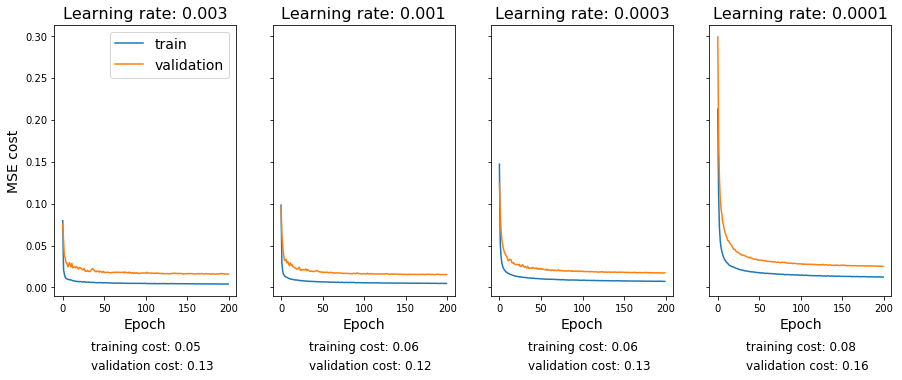

In [85]:
plot_hpram_cost(models_lr, 'Learning rate', learning_rates)

In all four models above, we observe a decreasing trend in the training and validation costs - both good signs - showing the learning is not too large to make the model explode. 

Notice that the model with `learning_rate = 0.001` has a smaller validation cost but a larger training cost than the model with `learning_rate = 0.003`. The model with `learning_rate = 0.001` has the best performance on the validation set. 

In [86]:
learning_rate = 0.001

Now lets optimize the batch size following a similar procedure as before. 

Note that I used batch sizes of powers of 2. This decision is rooted in memory management to eliminate overflow into additional memory cells.

In [87]:
batch_sizes = [8, 16, 32, 64]
models_batch = optimize_batch_size(batch_sizes)

Train on 199 samples, validate on 43 samples
Epoch 1/200
199/199 [==============================] - 8s 40ms/step - loss: 0.0697 - mean_absolute_percentage_error: 1100098.4607 - val_loss: 0.0652 - val_mean_absolute_percentage_error: 1337991.2820
Epoch 2/200
199/199 [==============================] - 4s 19ms/step - loss: 0.0206 - mean_absolute_percentage_error: 862669.8090 - val_loss: 0.0512 - val_mean_absolute_percentage_error: 1213830.5349
Epoch 3/200
199/199 [==============================] - 4s 19ms/step - loss: 0.0156 - mean_absolute_percentage_error: 726969.2449 - val_loss: 0.0380 - val_mean_absolute_percentage_error: 1049820.1919
Epoch 4/200
199/199 [==============================] - 4s 19ms/step - loss: 0.0134 - mean_absolute_percentage_error: 730829.9851 - val_loss: 0.0337 - val_mean_absolute_percentage_error: 945533.2093
Epoch 5/200
199/199 [==============================] - 4s 19ms/step - loss: 0.0124 - mean_absolute_percentage_error: 667784.8263 - val_loss: 0.0318 - val_mean_

199/199 [==============================] - 5s 23ms/step - loss: 0.0064 - mean_absolute_percentage_error: 519784.4510 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 683145.5487
Epoch 42/200
199/199 [==============================] - 4s 22ms/step - loss: 0.0065 - mean_absolute_percentage_error: 509257.9717 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 756722.5320
Epoch 43/200
199/199 [==============================] - 4s 21ms/step - loss: 0.0065 - mean_absolute_percentage_error: 509629.7579 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 746893.3547
Epoch 44/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0064 - mean_absolute_percentage_error: 507800.9680 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 730441.0203
Epoch 45/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0064 - mean_absolute_percentage_error: 496261.1383 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 746493.4433
Epoch 46/200
199/1

199/199 [==============================] - 4s 21ms/step - loss: 0.0055 - mean_absolute_percentage_error: 486660.3349 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 638392.9644
Epoch 83/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0057 - mean_absolute_percentage_error: 453701.7253 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 636287.1722
Epoch 84/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0055 - mean_absolute_percentage_error: 469149.7054 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 656801.5727
Epoch 85/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0055 - mean_absolute_percentage_error: 466888.4077 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 648866.1810
Epoch 86/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0054 - mean_absolute_percentage_error: 464010.3122 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 646347.0981
Epoch 87/200
199/1

Epoch 123/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 480919.2908 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 608007.0836
Epoch 124/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0051 - mean_absolute_percentage_error: 462372.7384 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 602124.1214
Epoch 125/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0050 - mean_absolute_percentage_error: 476762.1771 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 613813.0850
Epoch 126/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0051 - mean_absolute_percentage_error: 470924.7809 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 617136.6904
Epoch 127/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0052 - mean_absolute_percentage_error: 453907.7775 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 603431.3815


Epoch 164/200
199/199 [==============================] - 4s 20ms/step - loss: 0.0048 - mean_absolute_percentage_error: 456113.0675 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 598777.7616
Epoch 165/200
199/199 [==============================] - 4s 22ms/step - loss: 0.0048 - mean_absolute_percentage_error: 442481.7521 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 596053.3590
Epoch 166/200
199/199 [==============================] - 4s 22ms/step - loss: 0.0048 - mean_absolute_percentage_error: 428403.0319 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 606361.5545
Epoch 167/200
199/199 [==============================] - 4s 21ms/step - loss: 0.0048 - mean_absolute_percentage_error: 437713.6997 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 623513.4586
Epoch 168/200
199/199 [==============================] - 4s 21ms/step - loss: 0.0047 - mean_absolute_percentage_error: 429444.5789 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 589129.2267


Epoch 5/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0143 - mean_absolute_percentage_error: 738701.0318 - val_loss: 0.0380 - val_mean_absolute_percentage_error: 996903.5610
Epoch 6/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0132 - mean_absolute_percentage_error: 737424.2999 - val_loss: 0.0383 - val_mean_absolute_percentage_error: 950862.5814
Epoch 7/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0124 - mean_absolute_percentage_error: 658511.9287 - val_loss: 0.0343 - val_mean_absolute_percentage_error: 923083.7674
Epoch 8/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0118 - mean_absolute_percentage_error: 679513.9108 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 807119.6163
Epoch 9/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0115 - mean_absolute_percentage_error: 660025.7271 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 877101.2791
Epoch 10/2

199/199 [==============================] - 2s 12ms/step - loss: 0.0067 - mean_absolute_percentage_error: 545457.3598 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 625045.6991
Epoch 47/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 503972.7224 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 654988.2849
Epoch 48/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0066 - mean_absolute_percentage_error: 520477.0225 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 648652.9259
Epoch 49/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 557462.7106 - val_loss: 0.0171 - val_mean_absolute_percentage_error: 638451.7456
Epoch 50/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0067 - mean_absolute_percentage_error: 517947.9824 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 664159.0741
Epoch 51/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 500869.1047 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 618904.2238
Epoch 88/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 477201.6888 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 568284.1381
Epoch 89/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0058 - mean_absolute_percentage_error: 493542.2722 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 584169.2936
Epoch 90/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0057 - mean_absolute_percentage_error: 482861.0466 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 595658.3648
Epoch 91/200
199/199 [==============================] - 2s 12ms/step - loss: 0.0058 - mean_absolute_percentage_error: 485303.9615 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 619178.0756
Epoch 92/200
199/1

199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 478363.5638 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 554670.8779
Epoch 129/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 453115.4545 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 593024.5988
Epoch 130/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 468829.9698 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 572188.9724
Epoch 131/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0052 - mean_absolute_percentage_error: 435653.5267 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 583166.0145
Epoch 132/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0053 - mean_absolute_percentage_error: 474492.7285 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 577081.6206
Epoch 133/200


199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 447033.8994 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 550301.2195
Epoch 170/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 460031.1945 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 530735.0581
Epoch 171/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 447240.4127 - val_loss: 0.0145 - val_mean_absolute_percentage_error: 571232.7980
Epoch 172/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0050 - mean_absolute_percentage_error: 468122.1216 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 591092.2049
Epoch 173/200
199/199 [==============================] - 2s 11ms/step - loss: 0.0049 - mean_absolute_percentage_error: 477724.0425 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 549353.5872
Epoch 174/200


Epoch 10/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0128 - mean_absolute_percentage_error: 719662.9892 - val_loss: 0.0339 - val_mean_absolute_percentage_error: 972841.3140
Epoch 11/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0129 - mean_absolute_percentage_error: 704800.8382 - val_loss: 0.0310 - val_mean_absolute_percentage_error: 927608.1628
Epoch 12/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0120 - mean_absolute_percentage_error: 698533.5925 - val_loss: 0.0270 - val_mean_absolute_percentage_error: 950037.0276
Epoch 13/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0119 - mean_absolute_percentage_error: 702027.7327 - val_loss: 0.0273 - val_mean_absolute_percentage_error: 917515.0247
Epoch 14/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0118 - mean_absolute_percentage_error: 674315.3935 - val_loss: 0.0246 - val_mean_absolute_percentage_error: 901121.6294
Epoch 15/2

199/199 [==============================] - 2s 8ms/step - loss: 0.0077 - mean_absolute_percentage_error: 527192.7934 - val_loss: 0.0189 - val_mean_absolute_percentage_error: 747684.5145
Epoch 52/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0075 - mean_absolute_percentage_error: 532679.3288 - val_loss: 0.0192 - val_mean_absolute_percentage_error: 721223.8154
Epoch 53/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0075 - mean_absolute_percentage_error: 527590.2308 - val_loss: 0.0194 - val_mean_absolute_percentage_error: 697269.3663
Epoch 54/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0075 - mean_absolute_percentage_error: 530908.0338 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 719264.5567
Epoch 55/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0075 - mean_absolute_percentage_error: 553905.4403 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 653389.9724
Epoch 56/200
199/199 [=

199/199 [==============================] - 2s 8ms/step - loss: 0.0064 - mean_absolute_percentage_error: 519767.9417 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 696649.0698
Epoch 93/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0064 - mean_absolute_percentage_error: 486576.7899 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 689901.8605
Epoch 94/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0063 - mean_absolute_percentage_error: 489814.1244 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 709383.1890
Epoch 95/200
199/199 [==============================] - 2s 9ms/step - loss: 0.0064 - mean_absolute_percentage_error: 519182.5548 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 658084.9811
Epoch 96/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0063 - mean_absolute_percentage_error: 482964.6091 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 663003.6003
Epoch 97/200
199/199 [=

199/199 [==============================] - 2s 9ms/step - loss: 0.0058 - mean_absolute_percentage_error: 466986.9471 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 625403.3052
Epoch 134/200
199/199 [==============================] - 2s 9ms/step - loss: 0.0057 - mean_absolute_percentage_error: 475548.5088 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 634615.5392
Epoch 135/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0057 - mean_absolute_percentage_error: 464128.3883 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 647467.7471
Epoch 136/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0057 - mean_absolute_percentage_error: 449856.4650 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 667436.4608
Epoch 137/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0057 - mean_absolute_percentage_error: 502704.4973 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 608586.6628
Epoch 138/200
199/1

199/199 [==============================] - 2s 9ms/step - loss: 0.0054 - mean_absolute_percentage_error: 467192.6632 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 655994.9767
Epoch 175/200
199/199 [==============================] - 2s 9ms/step - loss: 0.0054 - mean_absolute_percentage_error: 483967.0911 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 650198.7922
Epoch 176/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0053 - mean_absolute_percentage_error: 465884.0233 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 635529.1105
Epoch 177/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0054 - mean_absolute_percentage_error: 481320.0386 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 639382.3227
Epoch 178/200
199/199 [==============================] - 2s 8ms/step - loss: 0.0056 - mean_absolute_percentage_error: 496180.0357 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 636137.8837
Epoch 179/200
199/1

199/199 [==============================] - 1s 6ms/step - loss: 0.0140 - mean_absolute_percentage_error: 702035.1096 - val_loss: 0.0377 - val_mean_absolute_percentage_error: 1142745.0000
Epoch 16/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0135 - mean_absolute_percentage_error: 742942.0364 - val_loss: 0.0387 - val_mean_absolute_percentage_error: 1044313.1250
Epoch 17/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0135 - mean_absolute_percentage_error: 713849.4424 - val_loss: 0.0329 - val_mean_absolute_percentage_error: 1040531.0625
Epoch 18/200
199/199 [==============================] - 1s 5ms/step - loss: 0.0131 - mean_absolute_percentage_error: 739435.5634 - val_loss: 0.0386 - val_mean_absolute_percentage_error: 973692.2500
Epoch 19/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0133 - mean_absolute_percentage_error: 672817.1784 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 1046287.5625
Epoch 20/200
199/19

199/199 [==============================] - 1s 7ms/step - loss: 0.0086 - mean_absolute_percentage_error: 580261.4279 - val_loss: 0.0249 - val_mean_absolute_percentage_error: 773038.1875
Epoch 57/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0087 - mean_absolute_percentage_error: 579506.2283 - val_loss: 0.0231 - val_mean_absolute_percentage_error: 860905.9375
Epoch 58/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0087 - mean_absolute_percentage_error: 629289.4551 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 848559.2500
Epoch 59/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0086 - mean_absolute_percentage_error: 580174.5578 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 825989.3750
Epoch 60/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0085 - mean_absolute_percentage_error: 567868.5510 - val_loss: 0.0226 - val_mean_absolute_percentage_error: 823628.0625
Epoch 61/200
199/199 [=

199/199 [==============================] - 1s 7ms/step - loss: 0.0076 - mean_absolute_percentage_error: 542960.0777 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 740315.3750
Epoch 98/200
199/199 [==============================] - 1s 7ms/step - loss: 0.0076 - mean_absolute_percentage_error: 522344.8197 - val_loss: 0.0207 - val_mean_absolute_percentage_error: 827213.1875
Epoch 99/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0074 - mean_absolute_percentage_error: 577966.6831 - val_loss: 0.0206 - val_mean_absolute_percentage_error: 784027.0625
Epoch 100/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0075 - mean_absolute_percentage_error: 516785.4647 - val_loss: 0.0202 - val_mean_absolute_percentage_error: 759635.7500
Epoch 101/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0075 - mean_absolute_percentage_error: 525792.5261 - val_loss: 0.0198 - val_mean_absolute_percentage_error: 805142.2500
Epoch 102/200
199/199

199/199 [==============================] - 1s 6ms/step - loss: 0.0069 - mean_absolute_percentage_error: 523617.8364 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 739295.6250
Epoch 139/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0068 - mean_absolute_percentage_error: 581195.7286 - val_loss: 0.0176 - val_mean_absolute_percentage_error: 773612.4375
Epoch 140/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 505699.3562 - val_loss: 0.0175 - val_mean_absolute_percentage_error: 737027.1875
Epoch 141/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0066 - mean_absolute_percentage_error: 518626.5947 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 734814.3125
Epoch 142/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0067 - mean_absolute_percentage_error: 511256.7638 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 743914.2500
Epoch 143/200
199/1

199/199 [==============================] - 1s 6ms/step - loss: 0.0063 - mean_absolute_percentage_error: 498397.7800 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 747488.4375
Epoch 180/200
199/199 [==============================] - 1s 6ms/step - loss: 0.0064 - mean_absolute_percentage_error: 522171.3945 - val_loss: 0.0169 - val_mean_absolute_percentage_error: 736409.7500
Epoch 181/200
199/199 [==============================] - 1s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 498373.8109 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 728189.0000
Epoch 182/200
199/199 [==============================] - 1s 5ms/step - loss: 0.0063 - mean_absolute_percentage_error: 532934.5948 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 732056.0625
Epoch 183/200
199/199 [==============================] - 1s 5ms/step - loss: 0.0062 - mean_absolute_percentage_error: 502817.5038 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 699575.3750
Epoch 184/200
199/1

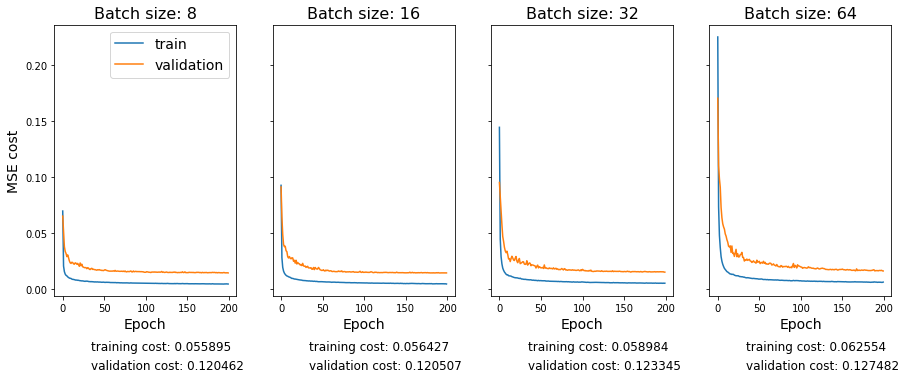

In [92]:
plot_hpram_cost(models_batch, 'Batch size', batch_sizes)

Observe above that the model with `batch_size = 8` outperforms the other models both in terms of training as well as validation costs. 

In [94]:
batch_size = 8

To conclude the model development and optimization section, lets use the tuned hyperparameters to plot the prediction of the model versus the actual security prices.

In [95]:
# reassigning variables for easier referal
model, history = models_batch[0]

# computing model predicitons
train_pred, valid_pred = model_predict(model)

# computing RMS cost
train_rms, valid_rms = model_cost(model)
print('train rms cost: ', train_rms)
print('valid rms cost: ', valid_rms)

train rms cost:  0.05589479140727538
valid rms cost:  0.12046221963364717


In [251]:
def plot_predictions(train_pred, valid_pred):
    '''
    Plots model predictions on the training and validation sets.
    
    Arguments:
    train_pred -- numpy array of shape (m_train, n_lables) containing the model predictions on the training set
    valid_pred -- numpy array of shape (m_valid, n_labels) containing the model predictions on the validation set
    '''
    # creating dummy variables for the x-axis
    xt = np.arange(train_pred.shape[0])
    xv = np.arange(train_pred.shape[0], train_pred.shape[0] + valid_pred.shape[0])        
    x = np.arange(train_pred.shape[0] + valid_pred.shape[0])
    
    # inverse scaling the predictions back to the original scale
    combined = np.concatenate((train_pred, valid_pred), axis=0)
    combined = inverse_scale(combined, stats)
    train_pred = combined[:train_pred.shape[0], :]
    valid_pred = combined[train_pred.shape[0]:, :]
    
    # inverse scaling the true labels back to the original scale
    true_labels = np.concatenate((y_train, y_valid), axis=0)
    true_labels = inverse_scale(true_labels, stats)
    
    # picking a random security to plot the model predictions on
    index = np.random.randint(train_pred.shape[1])
    
    # plotting
    plt.plot(xt, train_pred[:, index], label='train predictions')
    plt.plot(xv, valid_pred[:, index], label='validation predictions')
    plt.plot(x, true_labels[:, index], alpha=.5, label='true labels')
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Security price ($)', fontsize=12)
    plt.legend(loc=0, fontsize=12)
    plt.title('security x_' + str(index), fontsize=16)
    plt.show()

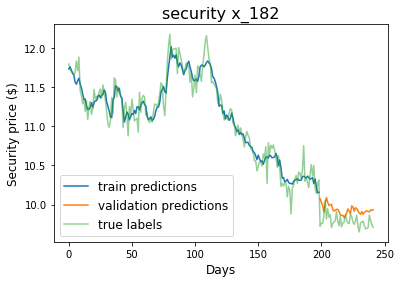

In [252]:
plot_predictions(train_pred, valid_pred)

## 3- Hedging basket proposal

In this section, I propose an algorithm to find a basket of securities, consisting of maximum five securities, to hedge the target security with. There are four target securities stored in `y.csv`, the price of which are tracked over the same period of time. 

In this section, we perform the following tasks:

1. Load and clean the target security data
    - we may require to perform data imputation and/or scaling similar to section 1 of this notebook
    - data visualiation will be helpful to get a better understanding of the target securities
2. Heding algorithm proposal

### 3.1- Load and clean data

In [118]:
df_y = pd.read_csv('data/y.csv')
print('shape of data:', df_y.shape)
df_y.head()

shape of data: (262, 5)


,Date,y_0,y_1,y_2,y_3
0,11/11/2014,12.123096,12.123096,12.123096,12.123096
1,12/11/2014,11.817700,12.226867,12.140312,12.157555
2,13/11/2014,12.022012,12.235446,12.125023,12.158846
3,14/11/2014,12.005934,12.315882,12.134531,12.158435
4,15/11/2014,11.925050,12.317324,12.116801,12.115347


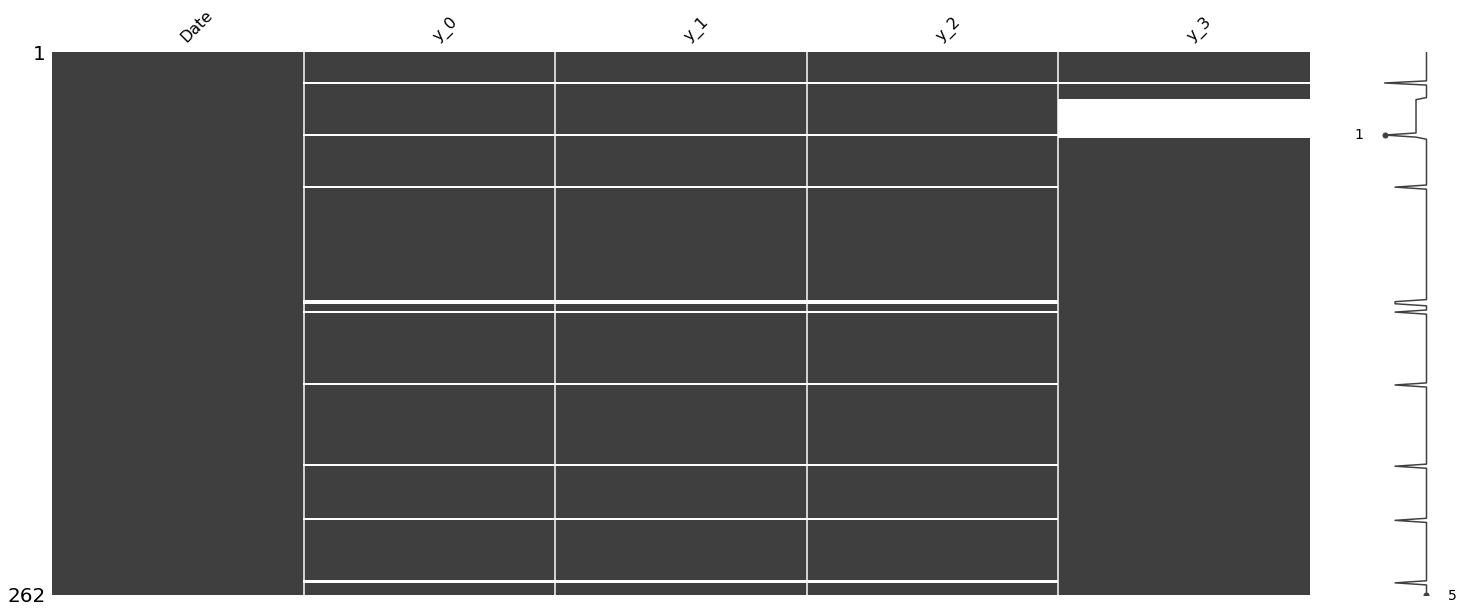

In [119]:
# lets see if we have missing values in the dataset
msno.matrix(df_y)

In [121]:
# imputing each missing value as the arithmetic mean of the previous and next values of the 
df_y_full = df_y.interpolate(method ='linear', limit_direction ='both') 

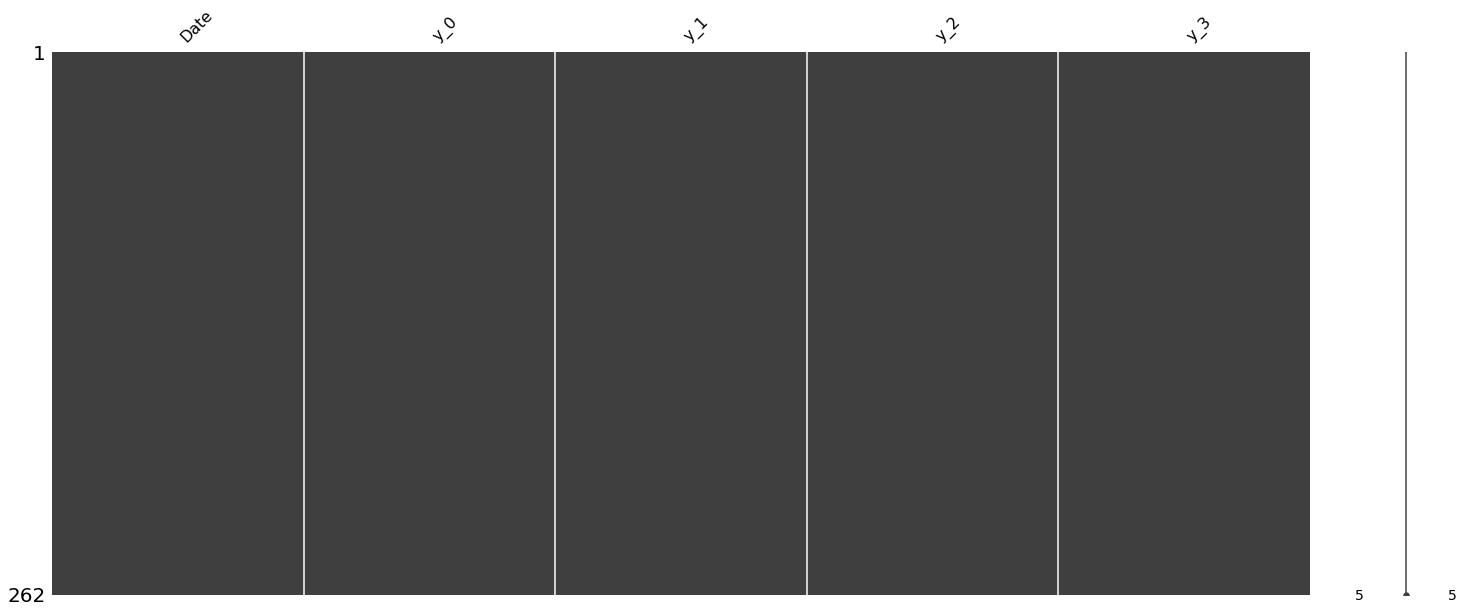

In [122]:
msno.matrix(df_y_full)

Lets now convert the dataset into a numpy array and scale the values. 

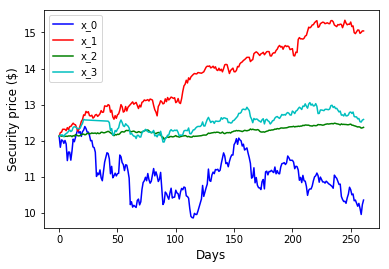

In [125]:
# converting the pandas data frame into a 2D numpy array
target = df_y_full.values

# removing the dates column from the target
target = target[:, 1:].astype(float)

# plotting the four target securities to observe their trends
indices = range(4)
plot_security(target, indices)

We now need to scale the data to (0, 1) range to feed into the model.

number of elements in the target dataset: 1048
number of elements in thes scaled target dataset: 1048


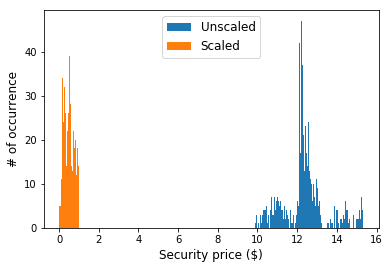

mean: 12.419167188707062
standard deviation: 1.141875873516895
max: 15.33842053
min: 9.860079602999999
# of elements <$1 0
# of elements <$10: 7
# of elements <$100: 1048


In [134]:
# sclaing the target dataset
target_scaled, stats_target = scale(target, feature_range)

# flattening the target dataset for easier plotting
target_flat = target.flatten()
target_scaled_flat = target_scaled.flatten()

# printing a few stats of the scaled dataset
print('number of elements in the target dataset:', len(target_flat))
print('number of elements in thes scaled target dataset:', len(target_scaled_flat))


# plotting the distribution of the scaled dataset compared to the unscaled version
plt.hist(target_flat, bins=200, label='Unscaled')
plt.hist(target_scaled_flat, bins=50, label='Scaled')
plt.ylabel('# of occurrence', fontsize=12)
plt.xlabel('Security price ($)', fontsize=12)
plt.legend(loc=0, fontsize=12)
plt.show()

# printing some stats about the unscaled target dataset
mu_target = target_flat.mean()
sigma_target = target_flat.std()
print('mean:', mu_target)
print('standard deviation:', sigma_target)
print('max:', target_flat.max())
print('min:', target_flat.min())
print('# of elements <$1', (target_flat < 1).sum())
print('# of elements <$10:', (target_flat<10).sum())
print('# of elements <$100:', (target_flat<100).sum())

Note that target securities have about the same mean as the training dataset. The target dataset's standard deviation is smaller, meaning that security values are more tightly distributed - as also evident by the min and max values. 

### 3.2- Heding basket proposal

Lets first define a metric to measure the performance of a security over a period of time. For this, I use the following formula

$$ gain(D_x(t_1), D_x(t_2)) = ln(D_x(t_2) / D_x(t_1)) \tag{1}$$

where $D_x(t)$ is the value of the security indexed $x$ from the dataset $D$ at time $t$. The advantage of this definition is that the log return over several period is the sum of individual returns. 

A negative gain indicates the price of the security depreciated over the period of time. Similarly, a positive gain indicates appreciation of the security price. 

We will use this definition to find a security with a similar gain (ie. performance) over a period of time as the target security we would like to hedge.

In [448]:
def gain(security, t1, t2):
    '''
    computes the gain of a security over a time period starting at t1 and ending at t2.
    
    Arguments:
    Security -- numpy array of shape (m, 1), where each entry is the security price at a time point
    t1 -- integer. index of the first time point
    t2 -- integer. index of the second time point
    
    Returns:
    g -- ln(security[t1] / security[t2])
    '''
    g = np.log(security[t1] / security[t2])
    return g


def basket_gain(basket, weights, t1, t2):
    '''
    Computes the gain of the entire basket over a period of time starting at t1 and ending at t2
    
    Argument:
    basket -- a list of integers. Each entry is the index of a security into the security dataset
    weights -- numpy vector, the same size as basket indicating the weights of corresponding securities in the basket
    t1 -- integer, indicating the starting point of the planning horizon
    t2 -- integer, indicating the ending point of the planning horizon
    
    Return:
    g -- float. Total gain of the basket
    '''
    # initializing the total gain to zero
    g = 0

    # looping through the securities in the basket
    for i in range(len(basket)):
        g += weights[0, i] * gain(dataset[:, basket[i]], t1, t2)
    
    return g


def basket_deviation(basket, target_index, t1, t2):
    '''
    Computes a single number indicating the standard deviation between the target security
    and the basket of securities from time point t1 to time point t2.
    
    Arguments:
    basket -- list of integers. Each entry is the index of a security in the basket
    target_index -- integer, indicating the index of the target security
    t1 -- integer, indicating the starting point of the planning horizon
    t2 -- integer, indicating the ending point of the planning horizon
    
    Returns:
    std_dev -- float, indicating the average of the standard deviations of the difference 
                between the target security and each of the securities in the basket
    '''.
    # computing the difference vector between the target and basket of securities
    delta = dataset[t1:t2, basket] - target[t1:t2, target_index].reshape((-1, 1))

    # computing the standard deviation of the difference between the target security
    # and each of the securities in the basket
    std_dev = np.std(delta, axis=0)
    
    # the final deviation is computed as the average of each standard deviation
    std_dev = np.mean(std_dev)
    return std_dev

The functions above compute the gain and deviation of a basket of securities. The gain is defined above. The deviation is computed as the average of the standard deviations of the differences between the target security and each of the securities in the basket. In mathematical terms, the deviation of a basket is defined as

$$ delta = D_B - T_y \tag{2}$$

where $D_B$ is the basket of securities and $T_y$ is the target security tracked over the same period of time. Python boradcasting is used. 

$$ deviation = mean(stddev(delta)) \tag{3}$$

Then the deviation of a basket of securities is defined as the mean of the standard deviations of each of the difference of the securities in the basket and the target security.

I now write a class to encapsulate a basket of securities. This object oriented design arises naturally from the structure of the problem and the attributes a target security and its hedging basket share. This section of code can also be implemented functionally, however, I think object oriented design is a better approach for this section of the problem.

In [501]:
class Basket(object):
    '''
    A class to represent a basket of securities
    '''

    def __init__(self, t1, t2, index):
        '''
        Arguments:
        t1 -- integer, indicating the starting point of the planning horizon
        t2 -- integer, indicating the ending point of the planning horizon
        index -- integer, index of the target security
        '''
        # float - gain of the current basket over the planning horizon
        self._basket_gain = -sys.float_info.max

        # float - gain of the target over the planning horizon
        self._target_gain = gain(target[:, index], t1, t2)

        # float - integer of the target security
        self._target_index = index

        # float - deviation of the basket from the target security
        self._basket_deviation = sys.float_info.max
                
        # integer - maximum number of securities that the hedging basket can hold
        self._max_securities = 5

        # list of integers - index of securities in the hedging basket
        self._basket = []

        # list of floats - each indicating the weight of the corresponding security
        self.initialize_weights()

        # integer - number of securities in the hedging basket
        self._num_securities = len(self._basket)

        # t1 & t2 both integers, indicating the starting and end point of the planning horizon
        self._t1 = t1
        self._t2 = t2
    
    
    def set_basket_gain(self):
        self._basket_gain = basket_gain(self._basket, self._weights, self._t1, self._t2)

        
    def set_target_gain(self):
        self._target_gain = gain(target[:, self._target_index], self._t1, self._t2)

        
    def set_target_index(self, new_index):
        self._target_index = new_index

        
    def _set_num_securities(self):
        self._num_securities = len(self._basket)

        
    def set_basket_deviation(self):
        self._basket_deviation = basket_deviation(self._basket, self._target_index, self._t1, self._t2)

        
    def initialize_weights(self):
        self._weights = np.ones((1, self._max_securities))
        w = 1 / self._max_securities
        self._weights *= w

        
    def get_basket_gain(self):
        return self._basket_gain

    
    def get_target_gain(self):
        return self._target_gain

    
    def get_target_index(self):
        return self._target_index

    
    def get_basket_deviation(self):
        return self._basket_deviation

    
    def get_basket(self):
        return self._basket

    
    def get_weights(self):
        return self._weights

    
    def _tryin(self, to_add):
        '''
        Returns true if the basket of securities consisting of the union of the current basket and the security indexed
        to_add has a lower deviation than the current basket by itself. False otherwise.

        Arguments:
        to_add -- integer, indicating the index of the security to be added to the basket

        Returns:
        new_deviation -- float, indicating the deviation of the basket if to_add was in the basket
        '''
        # making new new basket containing the new security index
        new_basket = self._basket.copy()
        new_basket.append(to_add)

        # computing the deviation of the new basket
        new_deviation = basket_deviation(new_basket, self._target_index, self._t1, self._t2)
        return new_deviation

    def _tryout(self, to_remove):
        '''
        Returns true if the basket of securities consisting of the current basket minus security indexed to_remove has
        a lower standard deviation than the current basket by itself. False otherwise

        Arguments:
        to_remove -- integer, indicating the index of the security to be removed from the basket

        Returns:
        new_deviation -- float, indicating the deviation of the basket if to_remove was not in the basket
        '''
        # making new new basket by removing the desired security index
        new_basket = self._basket.copy()
        new_basket.pop(to_remove)

        # computing the deviation of the new basket
        new_deviation = basket_deviation(new_basket, self._target_index, self._t1, self._t2)
        return False, new_deviation

    
    def _tryswop(self, to_add, to_remove):
        '''
        Returns true if the basket of securities consisting of the union of the current basket and the security indexed
        to_add minus the security indexed to_remove has a lower standard deviation than the current baskey by itself. False
        otherwise

        Arguments:
        to_add -- integer, indicating the index of the security to be added to the basket
        to_remove -- integer, indicating the index of the security to be removed from the basket

        Returns:
        new_deviation -- float, the deviation of the baket if to_add was and to_remove was not in the basket
        '''
        # making new new basket
        new_basket = self._basket.copy()
        new_basket.pop(to_remove)
        new_basket.append(to_add)

        # computing the deviation of the new basket
        new_deviation = basket_deviation(new_basket, self._target_index, self._t1, self._t2)
        return False, new_deviation

    
    def _include(self, to_add):
        '''
        Adds the security indexed to_add to the basket. Updates the basket's gain and deviation.

        Arguments:
        to_add -- integer, indicating the index of the security to be added to the basket
        '''
        self._basket.append(to_add)
        self._set_num_securities()
        self.set_basket_deviation()
        self.set_basket_gain()

        
    def _exclude(self, to_remove):
        '''
        Removes the security indexed to_remove from the basket. Updates the basket's gain and deviation.

        Arguments:
        to_remove -- integer, indicating the index of the security to be removed from the basket
        '''
        self._basket.pop(to_remove)
        self._set_num_securities()
        self.set_basket_deviation()
        self.set_basket_gain()

        
    def build_basket(self):
        added = []
        initial_deviation = self._basket_deviation

        # adding securities until we reach max number of securities in the basket
        while self._num_securities < self._max_securities:
            min_deviation = initial_deviation
            min_index = -1

            # looping through the dataset to find the security with smallest deviation
            for i in range(dataset.shape[1] - 2):
                if i not in added:
                    new_deviation = self._tryin(i)
                    if new_deviation < min_deviation:
                        min_deviation = new_deviation
                        min_index = i
            if min_index != -1:
                self._include(min_index)
                added.append(min_index)
            else:
                break

        # initializing and solving for the weight of each security
        self.initialize_weights()
        # self.solve_weights()

        
    def hedge_fund(self):
        '''
        Builds a fund consisting of the securities in the basket weighted by their corresponding weights

        Returns:
        fund -- numpy array of shape (t2-t1,), where each index is the weighted average of corresponding indices of
                securities in the basket
        '''
        fund = dataset[self._t1:self._t2, self._basket] * self._weights
        fund = np.sum(fund, axis=1)
        return fund

    
    def solve_weights(self):
        '''
        Finds the least square solution to XW=y, where X is the basket of securities and y is the target secuirty.
        '''
        y = target[self._t1:self._t2, self._target_index]
        X = dataset[self._t1:self._t2, self._basket]
        self._weights = np.linalg.lstsq(X, y, rcond=None)[0].reshape((1, -1))

To find a basket of securities to hedge the target security with, we start from an empty basket and iteratively add the security, from the universe of securities, that maximally reduces the basket deviation. We repeat this procedure unitl we reach the maximum number of securities in a basket (ie. five) or can not find a security to reduce the deviation of the basket from the target. 

Lets now loop through the target securities we would like to hedge and create a Basket object for each that will hold the basket of securities, from the universe of securities, for that particular target.

In [491]:
# for now, set the beginning and end of the planning horizon to two random numbers
t1 = np.random.randint(0, target.shape[0] - 1)
t2 = np.random.randint(t1, target.shape[0])

t1 = 0
t2 = dataset.shape[0] - 1

print('t1:', str(t1))
print('t2:', str(t2))

t1: 0
t2: 261


In [492]:
# a dictionary to map security index (ie. column number) to its corresponding Basket object
to_hedge = {}

# looping through target securities, creating a Basket object for each target security
for i in range(target.shape[1]):
    to_hedge[i] = Basket(t1, t2, i)
    
print('number of securities to hedge:', len(to_hedge))

number of securities to hedge: 4


We are now ready to construct a heding basket for each target security. The function below performs just that.

In [493]:
for i in range(len(to_hedge)):
    print('Before building a basket:', to_hedge[i].get_basket())
    to_hedge[i].build_basket()
    print('After building a basket:', to_hedge[i].get_basket())
    print('Target gain:', to_hedge[i].get_target_gain())
    print('Basket gain:', to_hedge[i].get_basket_gain())
    print()

Before building a basket: []
After building a basket: [391, 273, 282, 358, 74]
Target gain: 0.15767190831260344
Basket gain: 0.07706400141160294

Before building a basket: []
After building a basket: [125, 73, 140, 162, 318]
Target gain: -0.21571567036780329
Basket gain: -0.2080459946649414

Before building a basket: []
After building a basket: [167, 347, 443, 189, 253]
Target gain: -0.02014876284336643
Basket gain: -0.016184035195355072

Before building a basket: []
After building a basket: [223, 238, 306, 337, 348]
Target gain: -0.037656751351577165
Basket gain: -0.0585387729062697



Now lets plot the performance of the basket assuming **equal weights** for the securities in the basket.

In [494]:
def plot_hedgefund(hedge, target):
    '''
    Plots the basket performance as well as the target security over the planning horizon.
    
    ArgumentsL
    hedge -- numpy array, indicating the basket performance as the weighted sum of securities in the basket
    target -- numpy array, indicating the performance of the target security
    '''
    plt.plot(target, label='target security')
    plt.plot(hedge, label='basket performance')
    plt.legend(loc=0, fontsize=12)
    plt.ylabel('Security price ($)', fontsize=12)
    plt.xlabel('Days', fontsize=12)
    plt.title('')
    plt.show()

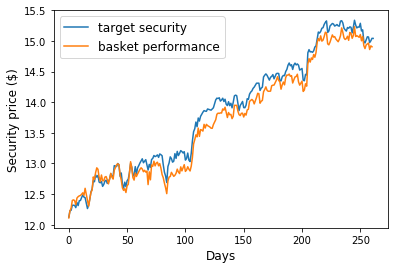

In [495]:
# choosing a target security and plotting the basket performance as well as target behaviour
index = 1
plot_hedgefund(to_hedge[index].hedge_fund(), target[:, index])

Now lets solve for basket security weights using the mathematical properties we know. Namely, 

$$ \sum_{i=1}^k W_i * X_i = T_y \tag{3}$$

where $X_i$'s are the securities in the basket and $W_i$'s are the corresponding weights. $T_y$ is the target security. The above equation can be written in the matrix form as

$$ XW = T_y \tag{4}$$

where X is the matrix made by stacking $X_i$'s in columns, and $W$ is a column vector of corresponding weights.
Also note that the above two equations are subject to

$$ \sum_{i=1}^k W_i = 1 \tag{5}$$

Now lets solve for the weights of the securities and plot the basket performance by accounting for the weight of each security in the basket. The function `solve_weights(...)` solves equation 4 to achieve this. 

In [496]:
# looping through target securities and solving for the weights of basket securities for each target
for i in range(len(to_hedge)):
    to_hedge[i].solve_weights()

Now plotting the performance of the basket assuming **unequal weights** for the securities in the basket.

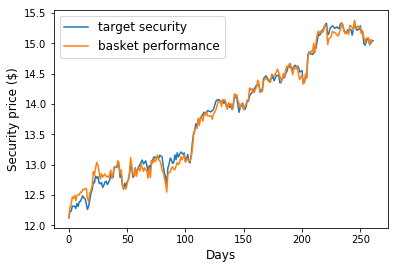

In [497]:
plot_hedgefund(to_hedge[index].hedge_fund(), target[:, index])

Now lets evaluate the performance of the basket over the planning horizon through the metric defined above - gain.

In [498]:
for i in range(len(to_hedge)):
    to_hedge[i].set_target_gain()
    to_hedge[i].set_basket_gain()
    print('target gain:', to_hedge[i].get_target_gain())
    print('basket gain:', to_hedge[i].get_basket_gain())
    print()

target gain: 0.15767190831260344
basket gain: 0.06899052172394096

target gain: -0.21571567036780329
basket gain: -0.21703816776625373

target gain: -0.02014876284336643
basket gain: -0.018040657779187327

target gain: -0.037656751351577165
basket gain: -0.0648363534736661



In [500]:
for i in range(len(to_hedge)):
    print('basket', i, 'deviation:', to_hedge[i].get_basket_deviation())

basket 0 deviation: 0.4665866107368902
basket 1 deviation: 0.1676261329856927
basket 2 deviation: 0.08996251363038209
basket 3 deviation: 0.17526915076935026
